# Import libraries and data

In [118]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import math
import statsmodels.api as sm
import scipy.stats as stats

from plotly.subplots import make_subplots

In [3]:
flights = pd.read_csv('./data_flight_20k.csv', sep = '\t')
sales = pd.read_csv('./data_sales_20k.csv', sep = ';')

# Data cleaning

## Flights dataset

This section studies the nature of the flights dataset, the distribution of the flight capacity, the number of flight numbers per departure airport, arrival airport and route group (here, there are sometimes more than 1 flight number, I doubt this is correct assuming that the flight number works as a unique identifier).

I also transform the time columns from strings to datetime for further work.

In [4]:
flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   InventoryLegSK          20000 non-null  int64 
 1   CarrierCode             20000 non-null  object
 2   FlightNumber            20000 non-null  int64 
 3   DepartureAirport        20000 non-null  object
 4   ArrivalAirport          20000 non-null  object
 5   DepartureDateTimeLocal  20000 non-null  object
 6   DepartureDateTimeUTC    20000 non-null  object
 7   ArrivalDateTimeLocal    20000 non-null  object
 8   ArrivalDateTimeUTC      20000 non-null  object
 9   ArrivalCountry          20000 non-null  object
 10  DepartureCountry        20000 non-null  object
 11  RouteGroup              20000 non-null  object
 12  Region                  20000 non-null  object
 13  FlightCapacity          20000 non-null  int64 
 14  FlightStatus            19917 non-null  object
dtypes:

In [5]:
flights['FlightCapacity'].describe()

count    20000.000000
mean       189.355600
std          3.290728
min        148.000000
25%        189.000000
50%        189.000000
75%        189.000000
max        197.000000
Name: FlightCapacity, dtype: float64

In [6]:
flights.groupby(['DepartureAirport', 'ArrivalAirport', 'RouteGroup']).count()['FlightNumber']

DepartureAirport  ArrivalAirport  RouteGroup
AAL               ARN             CITY          2
                  STN             CITY          1
AAR               AGP             LEISURE       2
                  MXP             CITY          4
                  STN             CITY          3
                                               ..
ZTH               FCO             LEISURE       2
                  MXP             LEISURE       5
                  NAP             LEISURE       2
                  STN             LEISURE       3
                  VIE             LEISURE       4
Name: FlightNumber, Length: 3578, dtype: int64

In [7]:
for column in ('DepartureDateTimeLocal', 'DepartureDateTimeUTC', 'ArrivalDateTimeLocal', 'ArrivalDateTimeUTC'):
    flights[column] = pd.to_datetime(flights[column])

## Sales dataset

This section studies the nature of the sales dataset, the distribution of the passenges tickets sold along with the ancillary products. As we can check, most of the time is difficult to sell an ancillary product, is not the usual.

I also transform the time column from string to datetime for further work, and transform the revenue from priority boarding in a float variable as well.

In [8]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 990568 entries, 0 to 990567
Data columns (total 10 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Unnamed: 0                    990568 non-null  int64  
 1   InventoryLegSK                990568 non-null  int64  
 2   PurchaseDateSK                986593 non-null  float64
 3   Passenger_UnitsSold           990568 non-null  float64
 4   Priority_Boarding_UnitsSold   987333 non-null  float64
 5   Priority_Boarding_RevenueEUR  990568 non-null  object 
 6   20KG_Bag_UnitsSold            980694 non-null  float64
 7   20KG_Bag_RevenueEUR           990568 non-null  float64
 8   10KG_Bag_UnitsSold            990568 non-null  float64
 9   10KG_Bag_RevenueEUR           990568 non-null  float64
dtypes: float64(7), int64(2), object(1)
memory usage: 75.6+ MB


In [9]:
sales.drop(columns = ['Unnamed: 0'], inplace = True)

In [10]:
sales['PurchaseDateSK'] = pd.to_datetime(sales['PurchaseDateSK'], format = '%Y%m%d')

In [11]:
sales['Priority_Boarding_RevenueEUR'] = sales['Priority_Boarding_RevenueEUR'].str.replace(',', '.').map(float)

In [12]:
sales.drop(columns = ['InventoryLegSK']).describe()

Passenger_UnitsSold  Priority_Boarding_UnitsSold  \
count        990568.000000                987333.000000   
mean              2.828692                     0.523152   
std               2.683455                     1.144100   
min               0.000000                     0.000000   
25%               1.000000                     0.000000   
50%               2.000000                     0.000000   
75%               4.000000                     1.000000   
max             189.000000                    81.000000   

       Priority_Boarding_RevenueEUR  20KG_Bag_UnitsSold  20KG_Bag_RevenueEUR  \
count                 990568.000000       980694.000000        990568.000000   
mean                       5.646875            0.327478            14.586731   
std                       12.917448            0.941385            41.956247   
min                        0.000000            0.000000             0.000000   
25%                        0.000000            0.000000             0.000000   
50%                        0.000000            0.000000             0.000000   
75%                        8.670000            0.000000             0.000000   
max                      681.330000           99.000000          5076.820000   

       10KG_Bag_UnitsSold  10KG_Bag_RevenueEUR  
count       990568.000000        990568.000000  
mean             0.132887             3.089844  
std              0.568395            13.121829  
min              0.000000             0.000000  
25%              0.000000             0.000000  
50%              0.000000             0.000000  
75%              0.000000             0.000000  
max            119.000000          1069.660000

# Possible factors that influence revenue

We've performed a multiple regression in each of the revenue obtained from ancillary products to determine wich were the more important factors in determining that revenue. We didn't perform a split of the sample in training and test set because we weren't focused on predictions, but on determining the impact and signifficance of each of these factors.

In general, we can conclude that the significance of the model is not very high in neither of the cases, indicating 

In [59]:
flights['flightDepartureLocalHour'] = flights['DepartureDateTimeLocal'].dt.hour
flights['flightArrivalLocalHour'] = flights['ArrivalDateTimeLocal'].dt.hour

In [60]:
data = flights[['InventoryLegSK', 'DepartureDateTimeUTC', 'ArrivalDateTimeUTC', 'RouteGroup', 'FlightCapacity', 'FlightStatus', 'flightDepartureLocalHour', 'flightArrivalLocalHour']]\
              .merge(sales, how = 'inner', on = 'InventoryLegSK')

In [61]:
data['timelapse'] = (data['DepartureDateTimeUTC'] - data['PurchaseDateSK']).apply(lambda x: x.days)
data['flight_length_min'] = (data['ArrivalDateTimeUTC'] - data['DepartureDateTimeUTC']).astype('timedelta64[m]')

In [62]:
for i in ('Priority_Boarding_RevenueEUR', '20KG_Bag_RevenueEUR', '10KG_Bag_RevenueEUR'):
    print('Model for ' + i + ':')
    data = pd.get_dummies(data[data[i] > 0])
    x = data.drop(columns = ['InventoryLegSK', 'DepartureDateTimeUTC', 'ArrivalDateTimeUTC', 'PurchaseDateSK',
                         'Passenger_UnitsSold', 'Priority_Boarding_UnitsSold',  'Priority_Boarding_RevenueEUR',
                         '20KG_Bag_UnitsSold', '20KG_Bag_RevenueEUR', '10KG_Bag_UnitsSold',	'10KG_Bag_RevenueEUR'
                        ])
    y = data[i]
    #add constant to predictor variables
    x = sm.add_constant(x)

    #fit linear regression model
    model = sm.OLS(y, x).fit()

    #view model summary
    print(model.summary())
    print('\r\n')

Model for Priority_Boarding_RevenueEUR:
                                 OLS Regression Results                                 
Dep. Variable:     Priority_Boarding_RevenueEUR   R-squared:                       0.022
Model:                                      OLS   Adj. R-squared:                  0.022
Method:                           Least Squares   F-statistic:                     707.5
Date:                          Mon, 30 Jan 2023   Prob (F-statistic):               0.00
Time:                                  13:43:32   Log-Likelihood:            -1.1859e+06
No. Observations:                        278059   AIC:                         2.372e+06
Df Residuals:                            278049   BIC:                         2.372e+06
Df Model:                                     9                                         
Covariance Type:                      nonrobust                                         
                               coef    std err          t      P>|t|  

# Days between flight purchase and flight departure, and ancillary products

Here, we will study the number of units sold of a certain type of luggage (or priority boarding), the revenue obtained per each of these products and the number of days before the flight departure. To do so, we have to join the information from both datasets.

In [16]:
data = flights[['InventoryLegSK', 'FlightNumber', 'DepartureDateTimeUTC', 'RouteGroup', 'FlightCapacity']].merge(sales, how = 'inner', on = 'InventoryLegSK')
drop_inventory =  data[data['PurchaseDateSK'] > data['DepartureDateTimeUTC']]['InventoryLegSK'].unique()

In [17]:
data = data[(~data['InventoryLegSK'].isin(drop_inventory)) & 
            (pd.isnull(data['PurchaseDateSK']) == False)
           ]

In [18]:
data['timelapse'] = (data['DepartureDateTimeUTC'] - data['PurchaseDateSK']).apply(lambda x: x.days)

Studying the correlation between the timelapse variable and the assets: as we can check, correlations are very low, almost unexistant, because of the distribution described when studying sales dataset: most of the dimes, ancillary products aren't sold. However, we can see that in the graphs that relates timelapse with the rest of the variables, as the timelapse approaches zero (i.e. there are less days between the flight departure and the buy of the seat), the revenue and units sold increase.

In [19]:
data.drop(columns = ['InventoryLegSK', 'FlightNumber', 'DepartureDateTimeUTC','PurchaseDateSK'])\
    .corr()

FlightCapacity  Passenger_UnitsSold  \
FlightCapacity                      1.000000             0.001139   
Passenger_UnitsSold                 0.001139             1.000000   
Priority_Boarding_UnitsSold        -0.000877             0.221418   
Priority_Boarding_RevenueEUR        0.000933             0.158016   
20KG_Bag_UnitsSold                 -0.006047             0.289585   
20KG_Bag_RevenueEUR                -0.008795             0.231691   
10KG_Bag_UnitsSold                 -0.000980             0.133832   
10KG_Bag_RevenueEUR                -0.001754             0.075470   
timelapse                           0.005003            -0.011392   

                              Priority_Boarding_UnitsSold  \
FlightCapacity                                  -0.000877   
Passenger_UnitsSold                              0.221418   
Priority_Boarding_UnitsSold                      1.000000   
Priority_Boarding_RevenueEUR                     0.955608   
20KG_Bag_UnitsSold                               0.070829   
20KG_Bag_RevenueEUR                              0.086931   
10KG_Bag_UnitsSold                               0.047067   
10KG_Bag_RevenueEUR                              0.071546   
timelapse                                       -0.094088   

                              Priority_Boarding_RevenueEUR  \
FlightCapacity                                    0.000933   
Passenger_UnitsSold                               0.158016   
Priority_Boarding_UnitsSold                       0.955608   
Priority_Boarding_RevenueEUR                      1.000000   
20KG_Bag_UnitsSold                                0.074123   
20KG_Bag_RevenueEUR                               0.104414   
10KG_Bag_UnitsSold                                0.066000   
10KG_Bag_RevenueEUR                               0.104224   
timelapse                                        -0.132854   

                              20KG_Bag_UnitsSold  20KG_Bag_RevenueEUR  \
FlightCapacity                         -0.006047            -0.008795   
Passenger_UnitsSold                     0.289585             0.231691   
Priority_Boarding_UnitsSold             0.070829             0.086931   
Priority_Boarding_RevenueEUR            0.074123             0.104414   
20KG_Bag_UnitsSold                      1.000000             0.948078   
20KG_Bag_RevenueEUR                     0.948078             1.000000   
10KG_Bag_UnitsSold                      0.053698             0.068281   
10KG_Bag_RevenueEUR                     0.065595             0.098601   
timelapse                               0.010337            -0.000895   

                              10KG_Bag_UnitsSold  10KG_Bag_RevenueEUR  \
FlightCapacity                         -0.000980            -0.001754   
Passenger_UnitsSold                     0.133832             0.075470   
Priority_Boarding_UnitsSold             0.047067             0.071546   
Priority_Boarding_RevenueEUR            0.066000             0.104224   
20KG_Bag_UnitsSold                      0.053698             0.065595   
20KG_Bag_RevenueEUR                     0.068281             0.098601   
10KG_Bag_UnitsSold                      1.000000             0.913149   
10KG_Bag_RevenueEUR                     0.913149             1.000000   
timelapse                              -0.062507            -0.088298   

                              timelapse  
FlightCapacity                 0.005003  
Passenger_UnitsSold           -0.011392  
Priority_Boarding_UnitsSold   -0.094088  
Priority_Boarding_RevenueEUR  -0.132854  
20KG_Bag_UnitsSold             0.010337  
20KG_Bag_RevenueEUR           -0.000895  
10KG_Bag_UnitsSold            -0.062507  
10KG_Bag_RevenueEUR           -0.088298  
timelapse                      1.000000

array([[<AxesSubplot:xlabel='FlightCapacity', ylabel='FlightCapacity'>,
        <AxesSubplot:xlabel='Priority_Boarding_RevenueEUR', ylabel='FlightCapacity'>,
        <AxesSubplot:xlabel='20KG_Bag_RevenueEUR', ylabel='FlightCapacity'>,
        <AxesSubplot:xlabel='10KG_Bag_RevenueEUR', ylabel='FlightCapacity'>,
        <AxesSubplot:xlabel='timelapse', ylabel='FlightCapacity'>],
       [<AxesSubplot:xlabel='FlightCapacity', ylabel='Priority_Boarding_RevenueEUR'>,
        <AxesSubplot:xlabel='Priority_Boarding_RevenueEUR', ylabel='Priority_Boarding_RevenueEUR'>,
        <AxesSubplot:xlabel='20KG_Bag_RevenueEUR', ylabel='Priority_Boarding_RevenueEUR'>,
        <AxesSubplot:xlabel='10KG_Bag_RevenueEUR', ylabel='Priority_Boarding_RevenueEUR'>,
        <AxesSubplot:xlabel='timelapse', ylabel='Priority_Boarding_RevenueEUR'>],
       [<AxesSubplot:xlabel='FlightCapacity', ylabel='20KG_Bag_RevenueEUR'>,
        <AxesSubplot:xlabel='Priority_Boarding_RevenueEUR', ylabel='20KG_Bag_RevenueEUR'>,
  

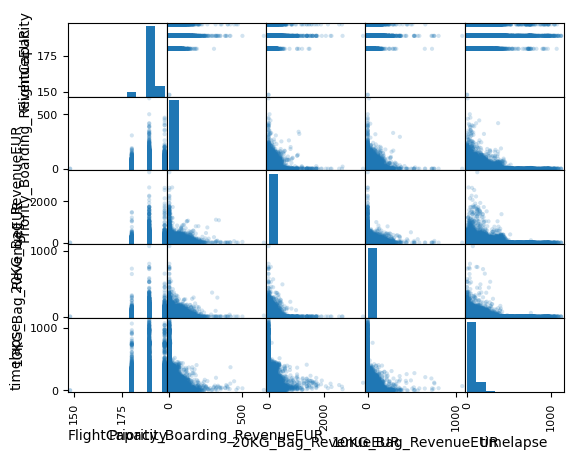

In [20]:
pd.plotting.scatter_matrix(data.drop(columns = ['InventoryLegSK', 'FlightNumber',
                                                'DepartureDateTimeUTC','PurchaseDateSK',
                                                'Passenger_UnitsSold', 'Priority_Boarding_UnitsSold',
                                                '20KG_Bag_UnitsSold', '10KG_Bag_UnitsSold']), alpha=0.2)

In [21]:
# data['timelapse'].describe()

In [22]:
# px.box(data['timelapse'])

In [23]:
# data['timelapse_bins'] = pd.cut(data['timelapse'], bins = 34, right = True)

In [24]:
# data3 = data[data['10KG_Bag_RevenueEUR'] > 0].groupby(['timelapse_bins']).agg({'10KG_Bag_RevenueEUR': 'median', '10KG_Bag_UnitsSold': 'sum'}).reset_index()
# data3['timelapse_bins'] = data3['timelapse_bins'].apply(lambda x: math.ceil(x.left)).astype("int")

# subfig = make_subplots(specs=[[{"secondary_y": True}]])

# # create two independent figures with px.line each containing data from multiple columns
# fig = px.bar(data3, x = 'timelapse_bins', y = '10KG_Bag_RevenueEUR')
# fig2 = px.line(data3, x = 'timelapse_bins', y = '10KG_Bag_UnitsSold')
# fig2.update_traces(line_color='red')

# fig2.update_traces(yaxis="y2")

# subfig.add_traces(fig.data + fig2.data)
# subfig.layout.xaxis.title = "timelapse bins"
# subfig.layout.yaxis.title = "Median luggage price (EUR)"
# subfig.layout.yaxis2.title = "Total units sold"

# subfig.show()

10KG_Bag:


C:\Users\garji\AppData\Local\Temp\ipykernel_14540\2279041830.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2['timelapse_bins'] = pd.cut(data2['timelapse'], bins = 23, right = True)


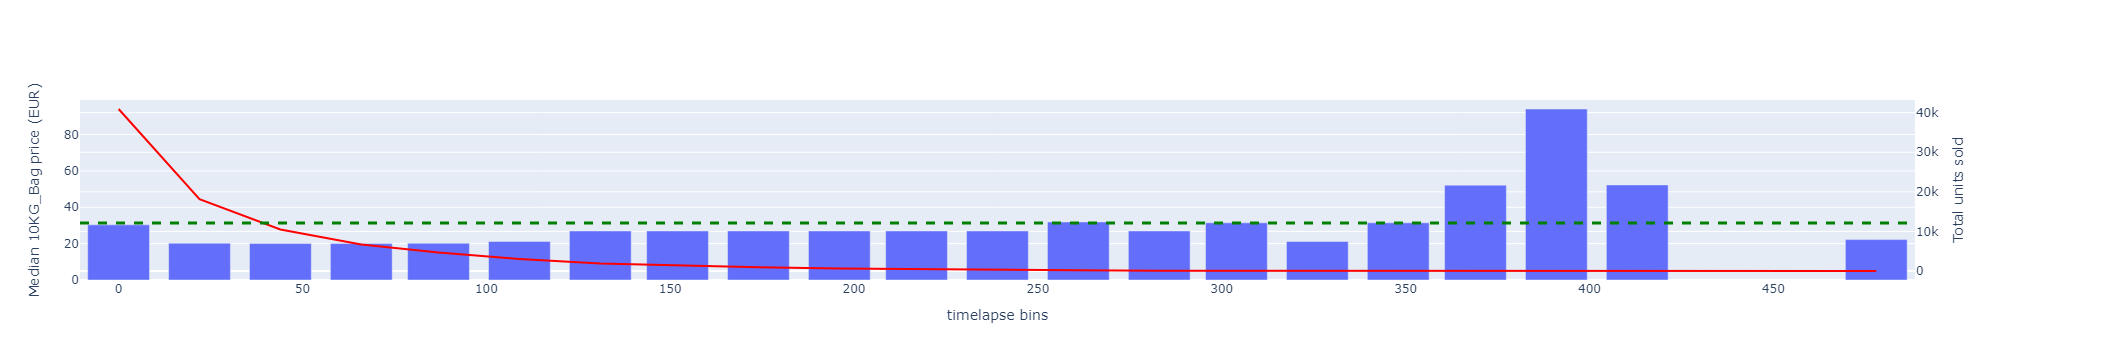



20KG_Bag:


C:\Users\garji\AppData\Local\Temp\ipykernel_14540\2279041830.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



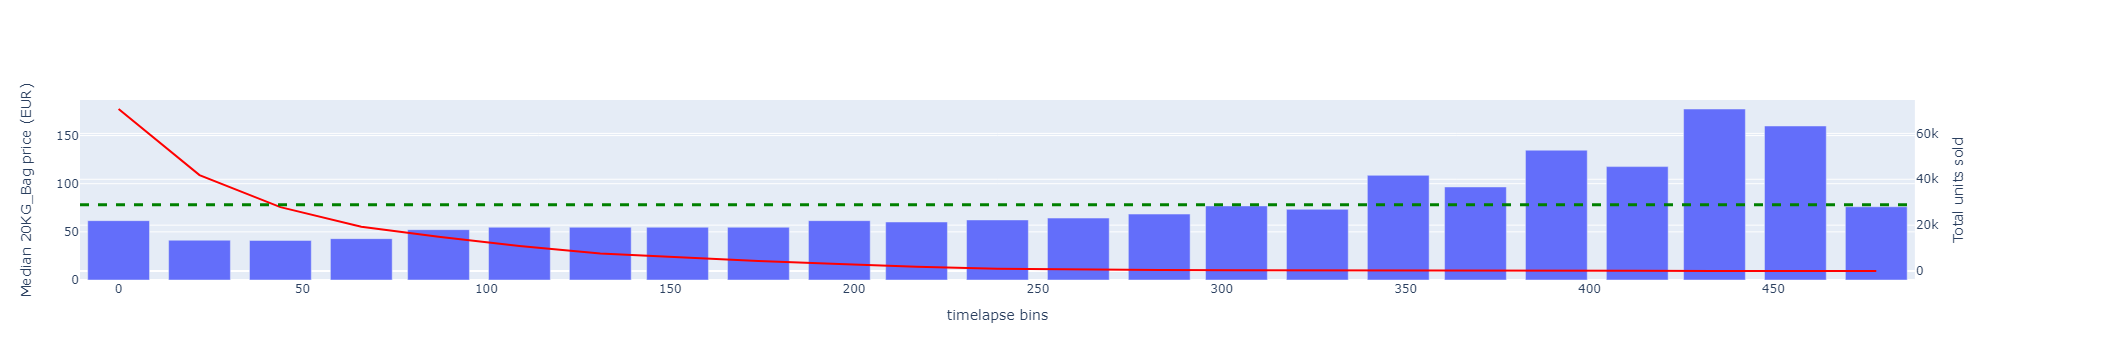



Priority_Boarding:


C:\Users\garji\AppData\Local\Temp\ipykernel_14540\2279041830.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



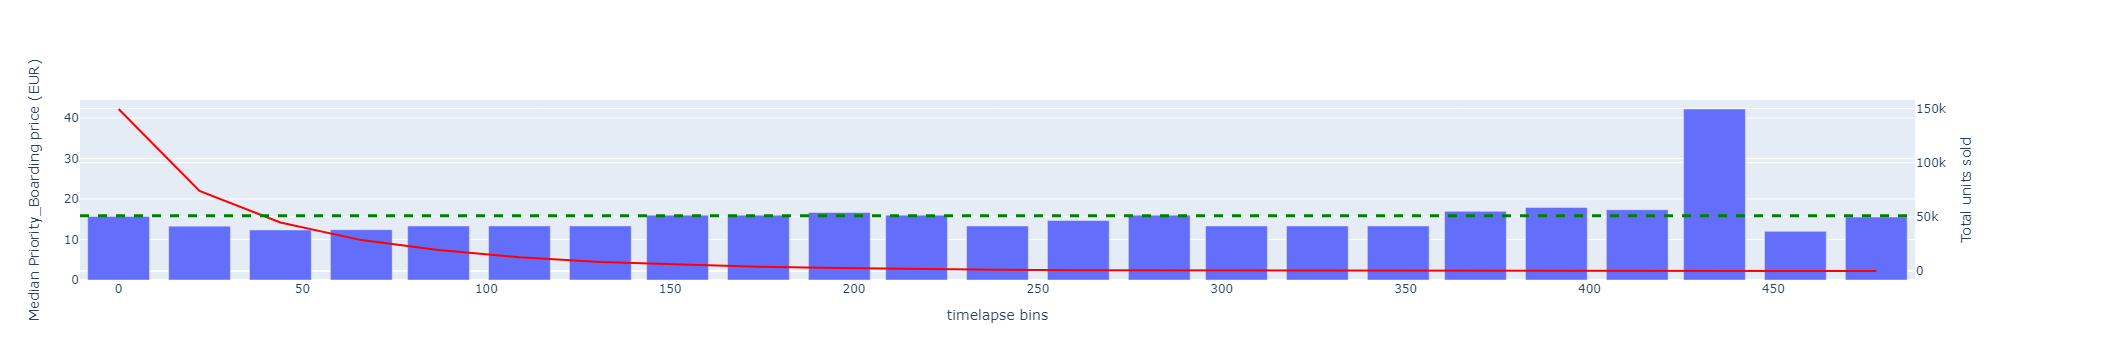

In [25]:
for i in ('10KG_Bag_', '20KG_Bag_', 'Priority_Boarding_'):
    print(i[:-1] + ':')
    data2 = data[data['timelapse'] < 500]
    data2['timelapse_bins'] = pd.cut(data2['timelapse'], bins = 23, right = True)
    data3 = data2[data2[i + 'RevenueEUR'] > 0].groupby(['timelapse_bins']).agg({i + 'RevenueEUR': 'median', i + 'UnitsSold': 'sum'}).reset_index()
    data3['timelapse_bins'] = data3['timelapse_bins'].apply(lambda x: math.ceil(x.left)).astype("int")

    subfig = make_subplots(specs=[[{"secondary_y": True}]])

    # create two independent figures with px.line each containing data from multiple columns
    fig = px.bar(data3, x = 'timelapse_bins', y = i + 'RevenueEUR')
    fig2 = px.line(data3, x = 'timelapse_bins', y = i + 'UnitsSold')
    fig2.update_traces(line_color='red')

    fig2.update_traces(yaxis="y2")

    subfig.add_traces(fig.data + fig2.data)
    subfig.layout.xaxis.title = "timelapse bins"
    subfig.layout.yaxis.title = 'Median ' + i[:-1] + ' price (EUR)'
    subfig.layout.yaxis2.title = "Total units sold"
    
    subfig.add_hline(y = np.mean(data3[i + 'RevenueEUR']), line_width=3, line_dash="dash", line_color="green")
    # subfig.add_hline(y = data3[i + 'RevenueEUR'].quantile(.75), line_width = 3, line_dash = "dash", line_color = "turquoise")
    

    subfig.show()
    subfig.write_html('./Graphs/' + i[:-1] + '.html')
    subfig.write_image('./Graphs/' + i[:-1] + '.png') 
    print('\r\n')

10KG_Bag, LEISURE:


C:\Users\garji\AppData\Local\Temp\ipykernel_14540\1662490005.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



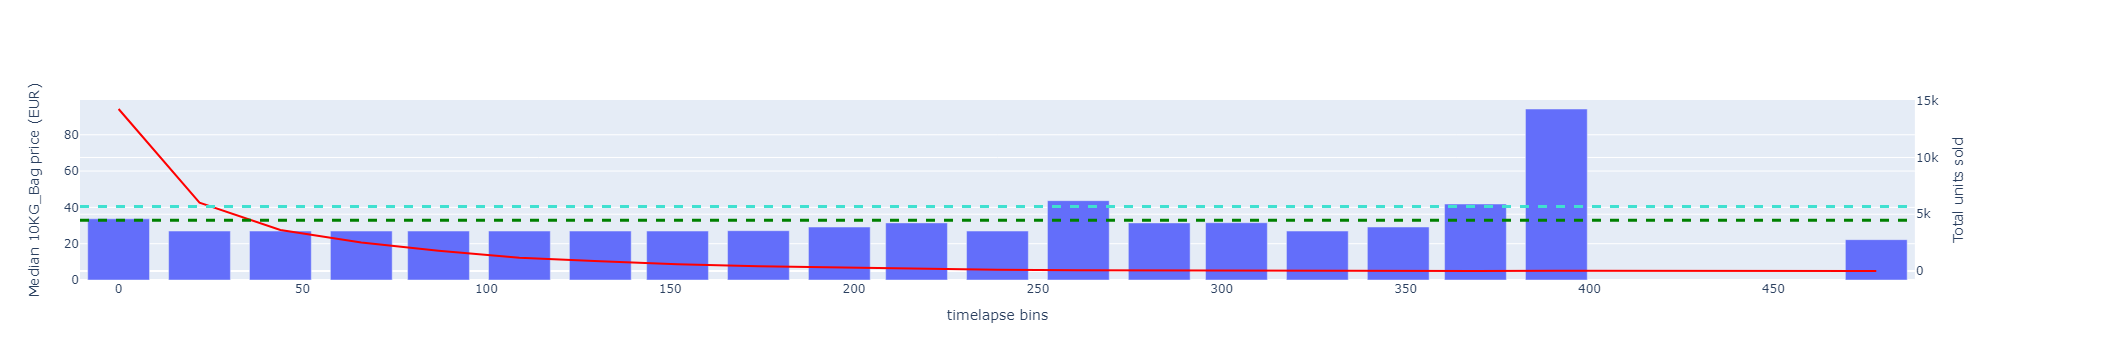



20KG_Bag, LEISURE:


C:\Users\garji\AppData\Local\Temp\ipykernel_14540\1662490005.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



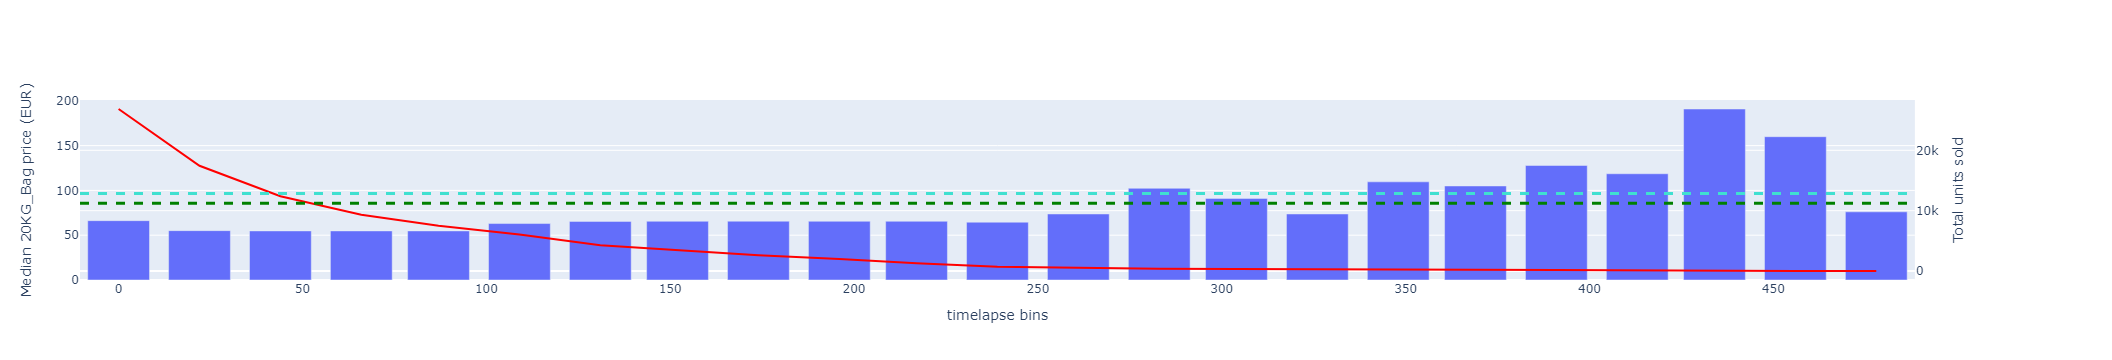



Priority_Boarding, LEISURE:


C:\Users\garji\AppData\Local\Temp\ipykernel_14540\1662490005.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



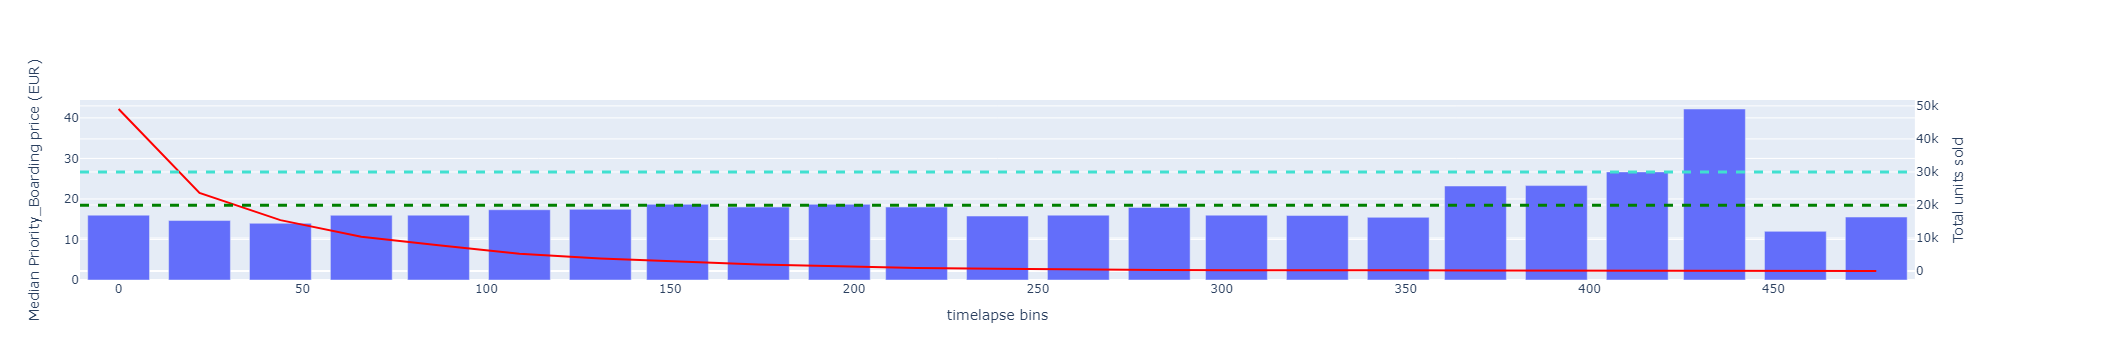



10KG_Bag, CITY:


C:\Users\garji\AppData\Local\Temp\ipykernel_14540\1662490005.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



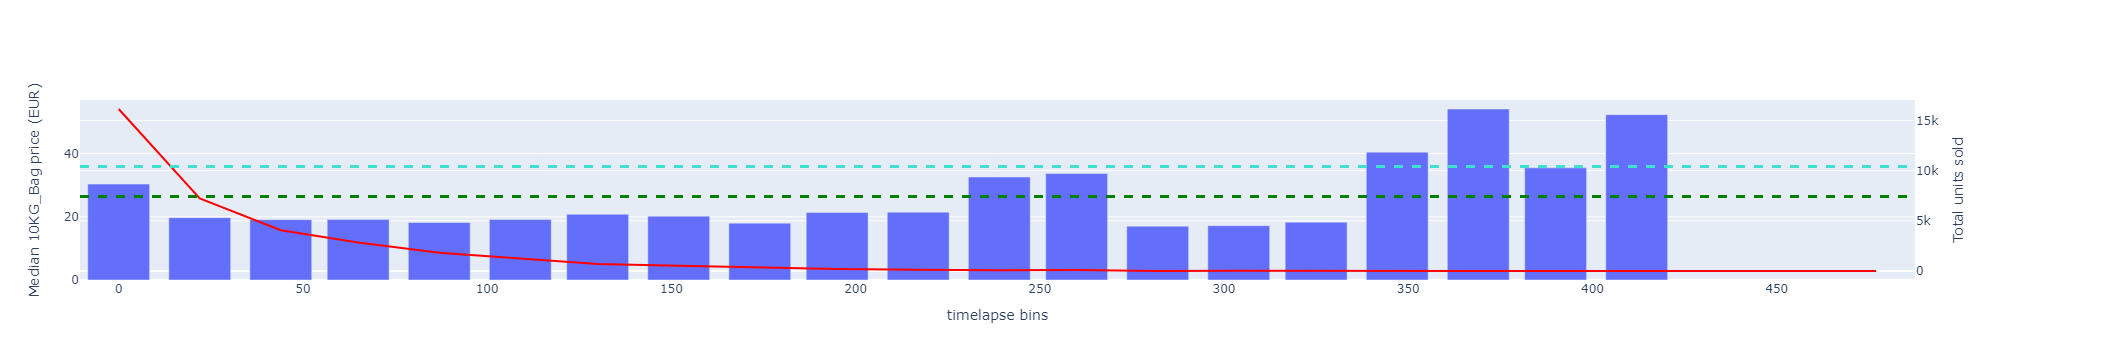



20KG_Bag, CITY:


C:\Users\garji\AppData\Local\Temp\ipykernel_14540\1662490005.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



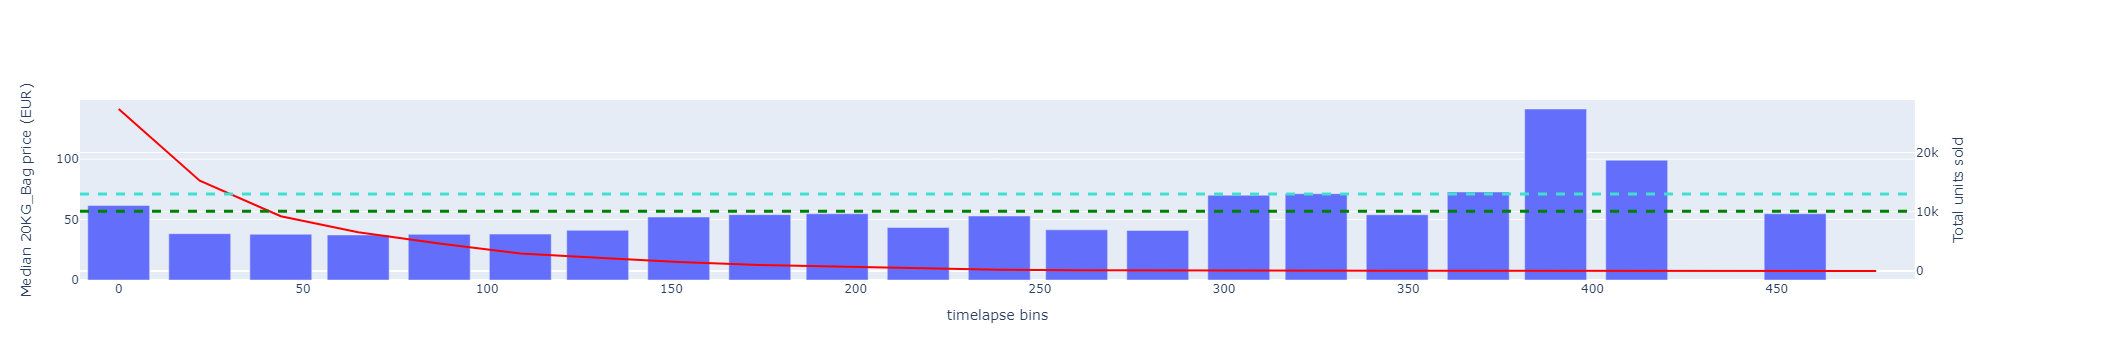



Priority_Boarding, CITY:


C:\Users\garji\AppData\Local\Temp\ipykernel_14540\1662490005.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



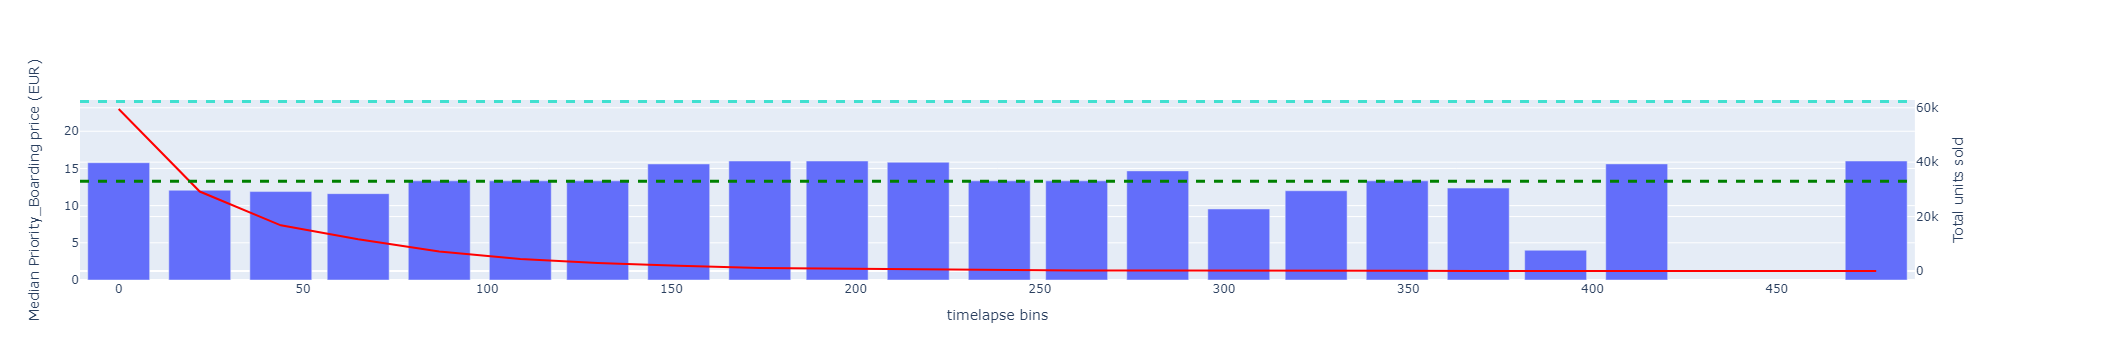



10KG_Bag, DOMESTIC:


C:\Users\garji\AppData\Local\Temp\ipykernel_14540\1662490005.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



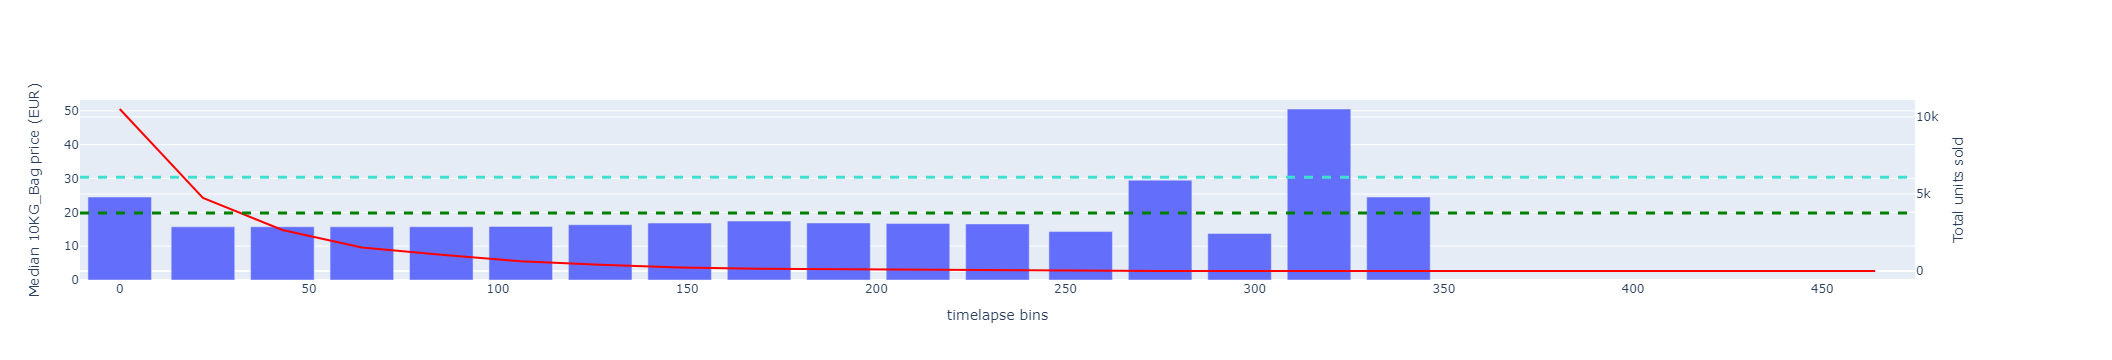



20KG_Bag, DOMESTIC:


C:\Users\garji\AppData\Local\Temp\ipykernel_14540\1662490005.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



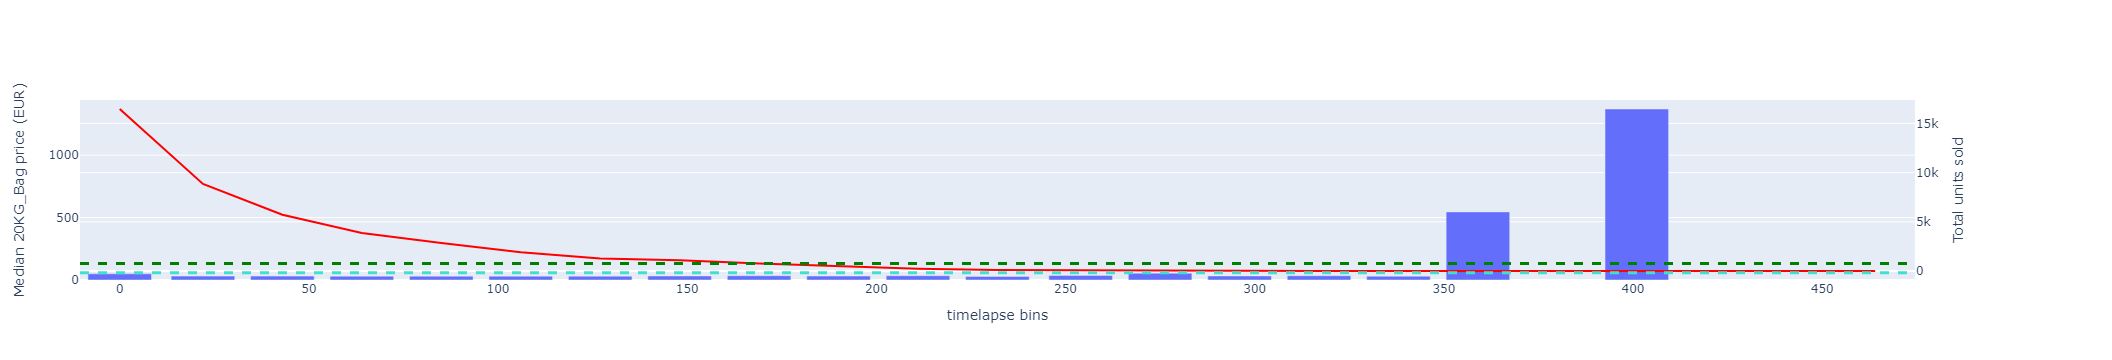



Priority_Boarding, DOMESTIC:


C:\Users\garji\AppData\Local\Temp\ipykernel_14540\1662490005.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



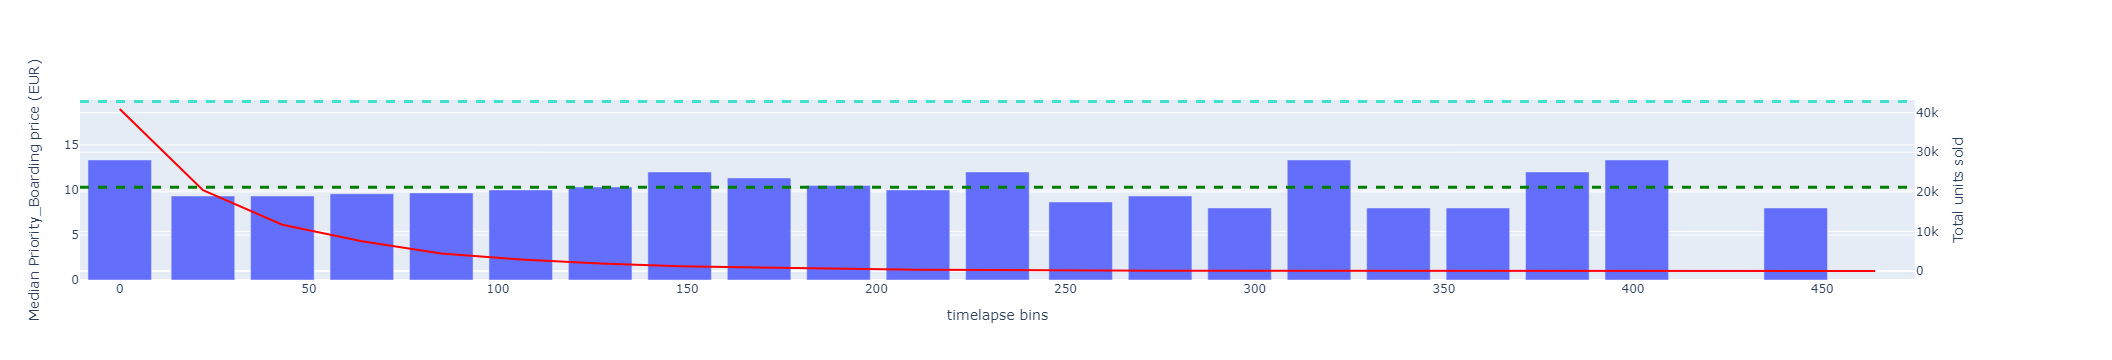

In [26]:
for flight in data['RouteGroup'].unique():
    for i in ('10KG_Bag_', '20KG_Bag_', 'Priority_Boarding_'):
        
        print(i[:-1] + ', ' + flight + ':')
        data2 = data[(data['timelapse'] < 500) & 
                     (data['RouteGroup'] == flight)]
        
        data2['timelapse_bins'] = pd.cut(data2['timelapse'], bins = 23, right = True)
        
        data3 = data2[data2[i + 'RevenueEUR'] > 0].groupby(['timelapse_bins']).agg({i + 'RevenueEUR': 'median', i + 'UnitsSold': 'sum'}).reset_index()
        data3['timelapse_bins'] = data3['timelapse_bins'].apply(lambda x: math.ceil(x.left)).astype("int")

        subfig = make_subplots(specs=[[{"secondary_y": True}]])

        # create two independent figures with px.line each containing data from multiple columns
        fig = px.bar(data3, x = 'timelapse_bins', y = i + 'RevenueEUR')
        fig2 = px.line(data3, x = 'timelapse_bins', y = i + 'UnitsSold')
        fig2.update_traces(line_color='red')

        fig2.update_traces(yaxis="y2")

        subfig.add_traces(fig.data + fig2.data)
        subfig.layout.xaxis.title = "timelapse bins"
        subfig.layout.yaxis.title = 'Median ' + i[:-1] + ' price (EUR)'
        subfig.layout.yaxis2.title = "Total units sold"
        
        subfig.add_hline(y = np.mean(data3[i + 'RevenueEUR']), line_width = 3, line_dash = "dash", line_color = "green")
        subfig.add_hline(y = data2[data2[i + 'RevenueEUR'] > 0][i + 'RevenueEUR'].quantile(.75), line_width = 3, line_dash = "dash", line_color = "turquoise")

        subfig.show()
        
        subfig.write_html('./Graphs/' + i[:-1] + '_' + flight + '.html')
        subfig.write_image('./Graphs/' + i[:-1] + '_' + flight + '.png') 
    
        print('\r\n')

# Number of free seats before departure: extra luggage

In general, study the number of free seats still available a few days before the departure. Assuming that the average weight of a passenger is 76 kg, make a study of the number of possible suitcases (10 and 20 kg) that could be placed on cabin or the hold.

In [27]:
data2 = data.sort_values(by = ['InventoryLegSK', 'timelapse'], ascending = False)
# data2['inventory_by_timelapse'] = data2['InventoryLegSK'].map(str) + '-' + data2['timelapse'].map(str)
# .groupby(['InventoryLegSK' + '-' + 'timelapse']).agg({'Passenger_UnitsSold': 'cumsum'}).reset_index()

In [28]:
data2 = data2.merge(data2.groupby(['InventoryLegSK']).cumsum()['Passenger_UnitsSold'], how = 'inner', on = data2.index)

In [29]:
data2.rename(columns = {'Passenger_UnitsSold_y' : 'cumulative_Passengers_UnitsSold'}, inplace = True)

In [30]:
# data2['FlightCapacity'] = data2['FlightCapacity'].apply(lambda x: x[0])

In [31]:
data2.drop(columns = ['key_0'], inplace = True)

In [32]:
data2['seats_not_sold'] = data2['FlightCapacity'] - data2['cumulative_Passengers_UnitsSold']

In [33]:
data2 = data2[(data2['seats_not_sold'] >= 0) & 
              (data2['timelapse'] <= 10)]
data2['no_extra_20k_suitcases'] = (data2['seats_not_sold'] * 76 / 20).apply(lambda x: math.floor(x))
data2['no_extra_10k_suitcases'] = (data2['seats_not_sold'] * 76 / 10).apply(lambda x: math.floor(x))

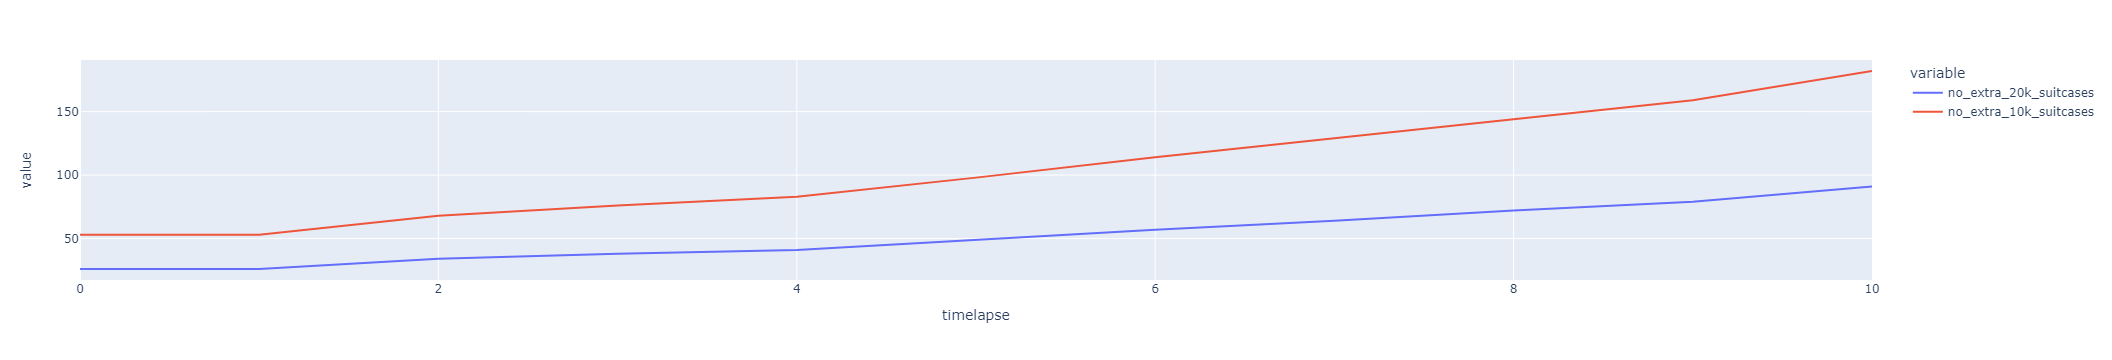

In [34]:
fig = px.line(data2.groupby('timelapse').median()[['no_extra_20k_suitcases', 'no_extra_10k_suitcases']].reset_index(),
                  x = 'timelapse', y = ['no_extra_20k_suitcases', 'no_extra_10k_suitcases'])
fig.show()

fig.write_html('./Graphs/Possible_suitcases_per_timelapse.html')
fig.write_image('./Graphs/Possible_suitcases_per_timelapse.png')

CITY:


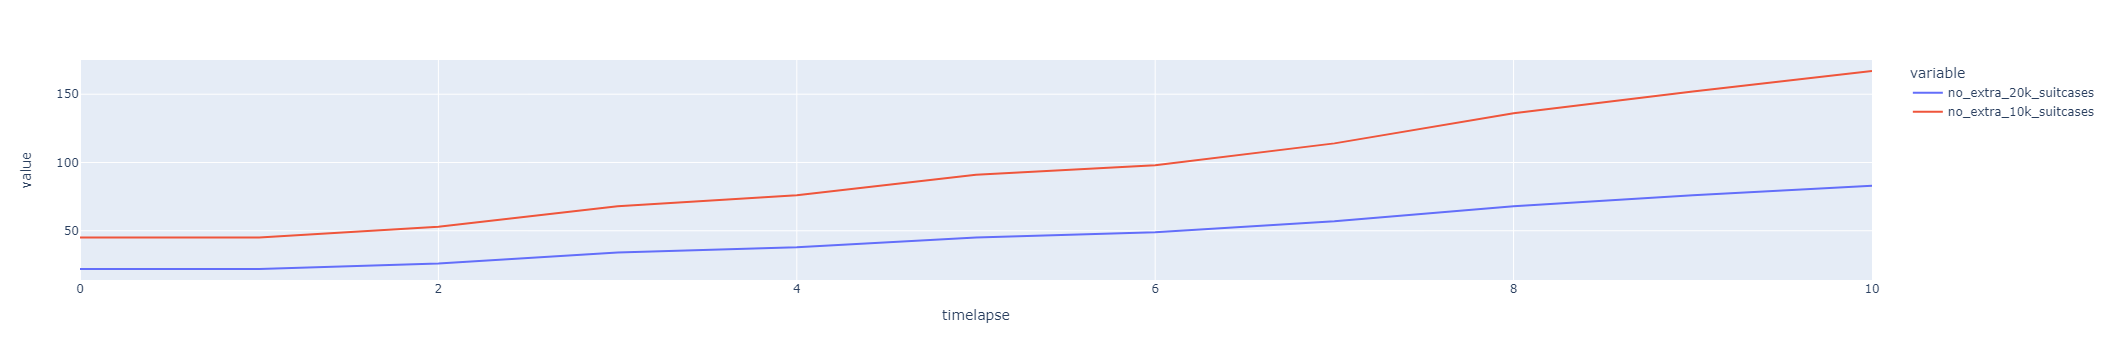



DOMESTIC:


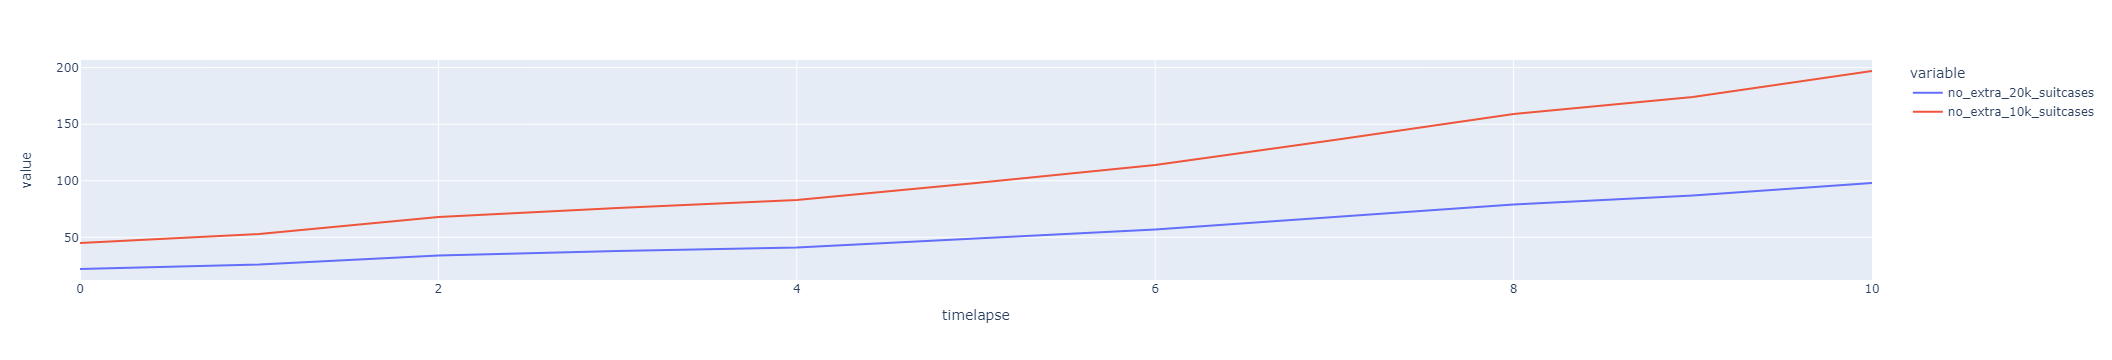



LEISURE:


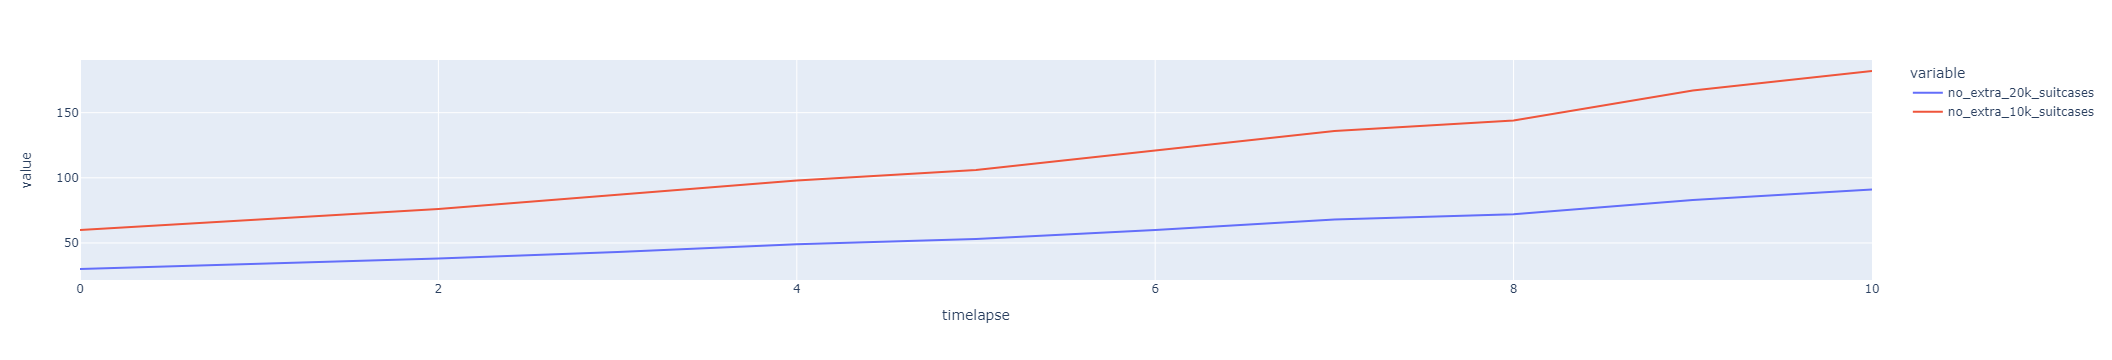

In [35]:
for i in data2['RouteGroup'].unique():
    print(i + ':')
    fig = px.line(data2[data2['RouteGroup'] == i].groupby('timelapse').median()[['no_extra_20k_suitcases', 'no_extra_10k_suitcases']].reset_index(),
                      x = 'timelapse', y = ['no_extra_20k_suitcases', 'no_extra_10k_suitcases'])
    fig.show()
    
    fig.write_html('./Graphs/Possible_suitcases_per_timelapse_' + i + '.html')
    fig.write_image('./Graphs/Possible_suitcases_per_timelapse_' + i + '.png')
    
    print('\r\n')

# Flight length and ancillary products

As we can observe in the graphs below, there is a relationship between the number of minutes of flight length and the price, both related in a direct proportional way.

We can increment the prices in the most demanded flights, such as the ones in flight lengths around 79 and 129 minutes.

In [36]:
data = flights[['InventoryLegSK', 'RouteGroup', 'DepartureDateTimeUTC', 'ArrivalDateTimeUTC']]\
              .merge(sales, how = 'inner', on = 'InventoryLegSK')

In [38]:
data['flight_length_min'] = (data['ArrivalDateTimeUTC'] - data['DepartureDateTimeUTC']).astype('timedelta64[m]')

In [39]:
data.drop(columns = ['InventoryLegSK', 'DepartureDateTimeUTC','PurchaseDateSK', 'ArrivalDateTimeUTC'])\
    .corr()

Passenger_UnitsSold  \
Passenger_UnitsSold                      1.000000   
Priority_Boarding_UnitsSold              0.225149   
Priority_Boarding_RevenueEUR             0.160702   
20KG_Bag_UnitsSold                       0.293634   
20KG_Bag_RevenueEUR                      0.231295   
10KG_Bag_UnitsSold                       0.133055   
10KG_Bag_RevenueEUR                      0.075125   
flight_length_min                       -0.048166   

                              Priority_Boarding_UnitsSold  \
Passenger_UnitsSold                              0.225149   
Priority_Boarding_UnitsSold                      1.000000   
Priority_Boarding_RevenueEUR                     0.955094   
20KG_Bag_UnitsSold                               0.073456   
20KG_Bag_RevenueEUR                              0.090149   
10KG_Bag_UnitsSold                               0.051504   
10KG_Bag_RevenueEUR                              0.076338   
flight_length_min                                0.001865   

                              Priority_Boarding_RevenueEUR  \
Passenger_UnitsSold                               0.160702   
Priority_Boarding_UnitsSold                       0.955094   
Priority_Boarding_RevenueEUR                      1.000000   
20KG_Bag_UnitsSold                                0.077913   
20KG_Bag_RevenueEUR                               0.109261   
10KG_Bag_UnitsSold                                0.071537   
10KG_Bag_RevenueEUR                               0.110011   
flight_length_min                                 0.019972   

                              20KG_Bag_UnitsSold  20KG_Bag_RevenueEUR  \
Passenger_UnitsSold                     0.293634             0.231295   
Priority_Boarding_UnitsSold             0.073456             0.090149   
Priority_Boarding_RevenueEUR            0.077913             0.109261   
20KG_Bag_UnitsSold                      1.000000             0.945167   
20KG_Bag_RevenueEUR                     0.945167             1.000000   
10KG_Bag_UnitsSold                      0.057573             0.072512   
10KG_Bag_RevenueEUR                     0.069831             0.103619   
flight_length_min                       0.078084             0.120955   

                              10KG_Bag_UnitsSold  10KG_Bag_RevenueEUR  \
Passenger_UnitsSold                     0.133055             0.075125   
Priority_Boarding_UnitsSold             0.051504             0.076338   
Priority_Boarding_RevenueEUR            0.071537             0.110011   
20KG_Bag_UnitsSold                      0.057573             0.069831   
20KG_Bag_RevenueEUR                     0.072512             0.103619   
10KG_Bag_UnitsSold                      1.000000             0.915936   
10KG_Bag_RevenueEUR                     0.915936             1.000000   
flight_length_min                       0.005439             0.030609   

                              flight_length_min  
Passenger_UnitsSold                   -0.048166  
Priority_Boarding_UnitsSold            0.001865  
Priority_Boarding_RevenueEUR           0.019972  
20KG_Bag_UnitsSold                     0.078084  
20KG_Bag_RevenueEUR                    0.120955  
10KG_Bag_UnitsSold                     0.005439  
10KG_Bag_RevenueEUR                    0.030609  
flight_length_min                      1.000000

array([[<AxesSubplot:xlabel='Passenger_UnitsSold', ylabel='Passenger_UnitsSold'>,
        <AxesSubplot:xlabel='Priority_Boarding_UnitsSold', ylabel='Passenger_UnitsSold'>,
        <AxesSubplot:xlabel='Priority_Boarding_RevenueEUR', ylabel='Passenger_UnitsSold'>,
        <AxesSubplot:xlabel='20KG_Bag_UnitsSold', ylabel='Passenger_UnitsSold'>,
        <AxesSubplot:xlabel='20KG_Bag_RevenueEUR', ylabel='Passenger_UnitsSold'>,
        <AxesSubplot:xlabel='10KG_Bag_UnitsSold', ylabel='Passenger_UnitsSold'>,
        <AxesSubplot:xlabel='10KG_Bag_RevenueEUR', ylabel='Passenger_UnitsSold'>,
        <AxesSubplot:xlabel='flight_length_min', ylabel='Passenger_UnitsSold'>],
       [<AxesSubplot:xlabel='Passenger_UnitsSold', ylabel='Priority_Boarding_UnitsSold'>,
        <AxesSubplot:xlabel='Priority_Boarding_UnitsSold', ylabel='Priority_Boarding_UnitsSold'>,
        <AxesSubplot:xlabel='Priority_Boarding_RevenueEUR', ylabel='Priority_Boarding_UnitsSold'>,
        <AxesSubplot:xlabel='20KG_Bag_Units

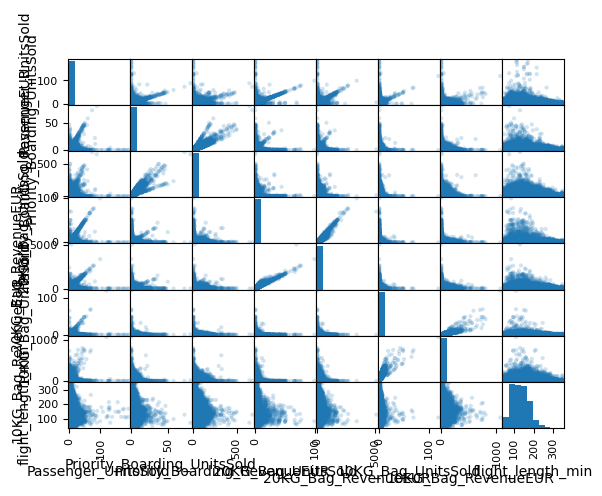

In [40]:
pd.plotting.scatter_matrix(data.drop(columns = ['InventoryLegSK', 'DepartureDateTimeUTC','PurchaseDateSK', 'ArrivalDateTimeUTC']), alpha=0.2)

In [41]:
data['flight_length_min'].describe()

count    990568.000000
mean        130.360862
std          42.783870
min          45.000000
25%          95.000000
50%         125.000000
75%         160.000000
max         345.000000
Name: flight_length_min, dtype: float64

10KG_Bag:


C:\Users\garji\AppData\Local\Temp\ipykernel_14540\1301869508.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



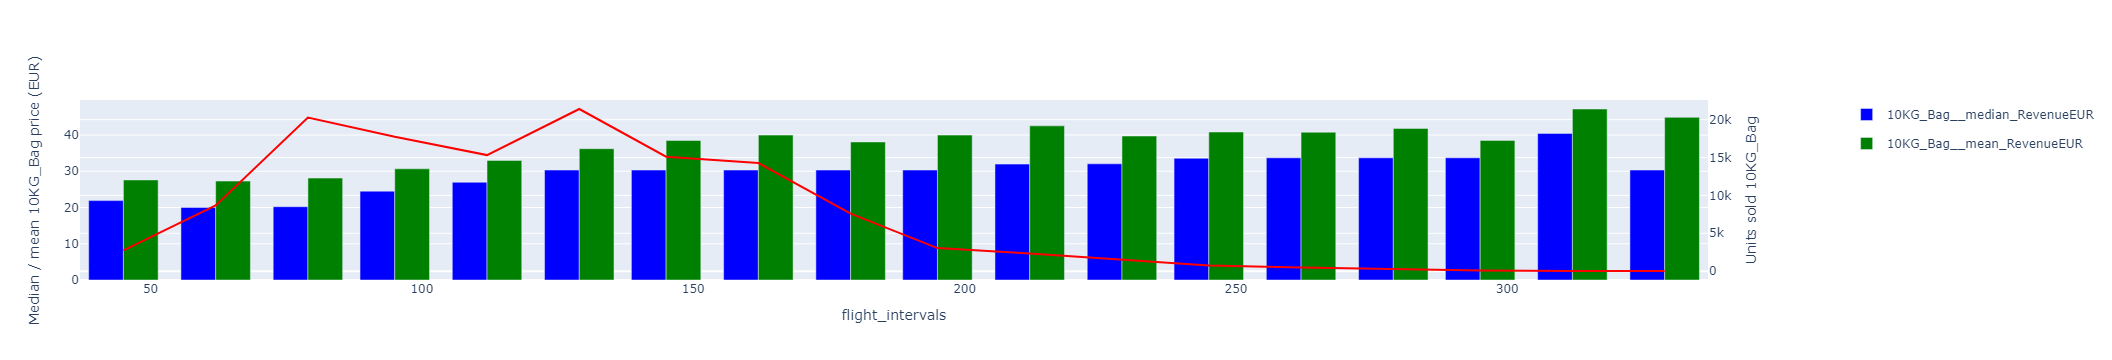



20KG_Bag:


C:\Users\garji\AppData\Local\Temp\ipykernel_14540\1301869508.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



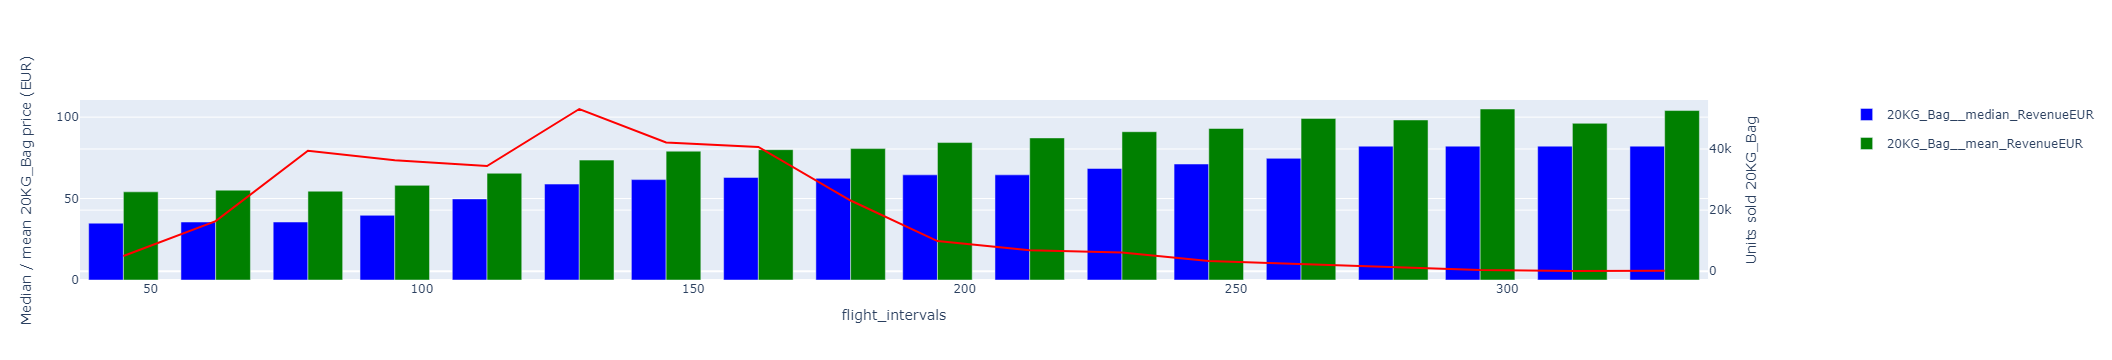



Priority_Boarding:


C:\Users\garji\AppData\Local\Temp\ipykernel_14540\1301869508.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



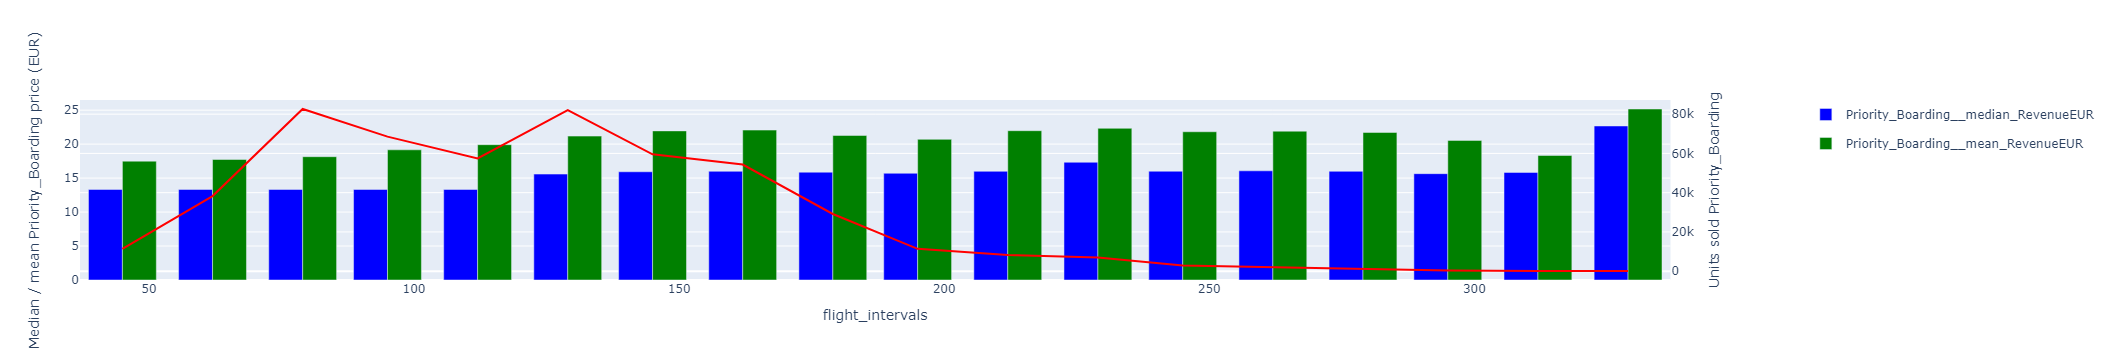

In [53]:
for i in ('10KG_Bag_', '20KG_Bag_', 'Priority_Boarding_'):
    print(i[:-1] + ':')
    data2 = data[data[i + 'RevenueEUR'] > 0]
    data2['flight_intervals'] = pd.cut(data2['flight_length_min'], bins = 18, right = True)
    data3 = data2.groupby(['flight_intervals']).agg({i + 'RevenueEUR': ['median', 'mean'], i + 'UnitsSold':	'sum'}).reset_index()
    data3['flight_intervals'] = data3['flight_intervals'].apply(lambda x: math.ceil(x.left)).astype("int")
    data3.columns = ['flight_intervals', i + '_median_' + 'RevenueEUR', i + '_mean_' + 'RevenueEUR', i + 'Units_sold']
    
    subfig = make_subplots(specs=[[{"secondary_y": True}]])
    
    color_discrete_map = {i + '_median_' + 'RevenueEUR': 'blue', i + '_mean_' + 'RevenueEUR': 'green'}

    # create two independent figures with px.line each containing data from multiple columns
    fig = px.bar(data3, x = 'flight_intervals', y = [i + '_median_' + 'RevenueEUR', i + '_mean_' + 'RevenueEUR'], color_discrete_map  = color_discrete_map)
    fig2 = px.line(data3, x = 'flight_intervals', y = i + 'Units_sold')
    fig2.update_traces(line_color = 'red')

    fig2.update_traces(yaxis="y2")

    subfig.add_traces(fig.data + fig2.data)
    subfig.layout.xaxis.title = "flight_intervals"
    subfig.layout.yaxis.title = 'Median / mean ' + i[:-1] + ' price (EUR)'
    subfig.layout.yaxis2.title = 'Units sold ' + i[:-1]
    
    # subfig.add_hline(y = np.mean(data3[i + 'RevenueEUR']), line_width=3, line_dash="dash", line_color="green")
    
    subfig.show()
    subfig.write_html('./Graphs/'+ i + 'mean_median_revenue_per_flight_length.html')
    subfig.write_image('./Graphs/'+ i + 'mean_median_revenue_per_flight_length.png')
    print('\r\n')

10KG_Bag, CITY:


C:\Users\garji\AppData\Local\Temp\ipykernel_14540\1814118050.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



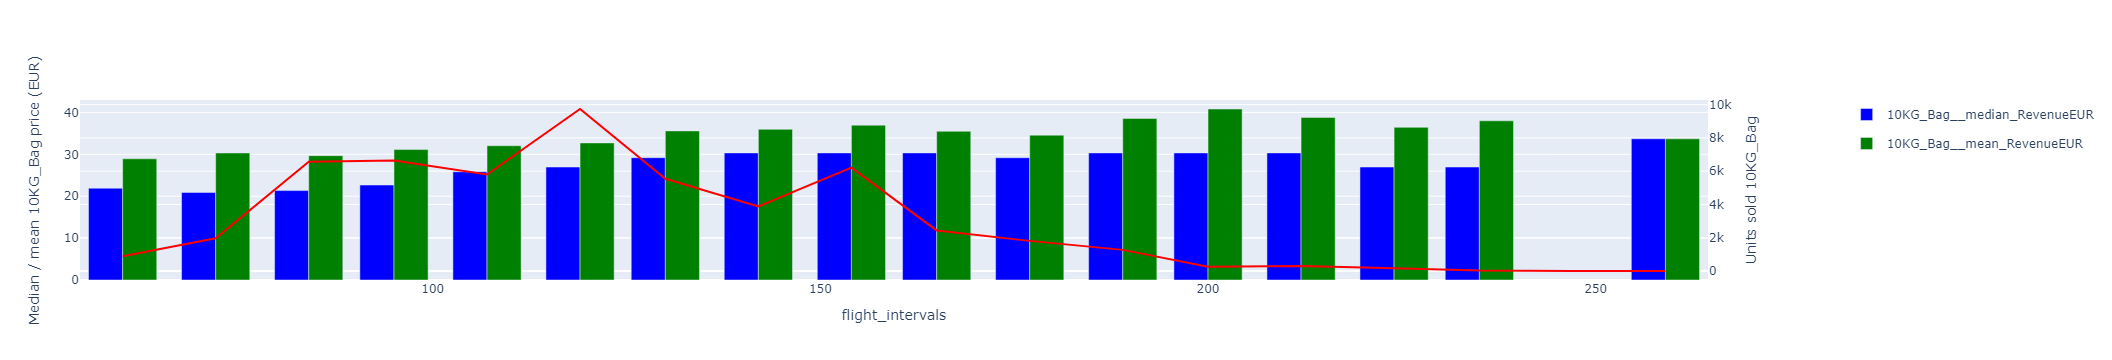



20KG_Bag, CITY:


C:\Users\garji\AppData\Local\Temp\ipykernel_14540\1814118050.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



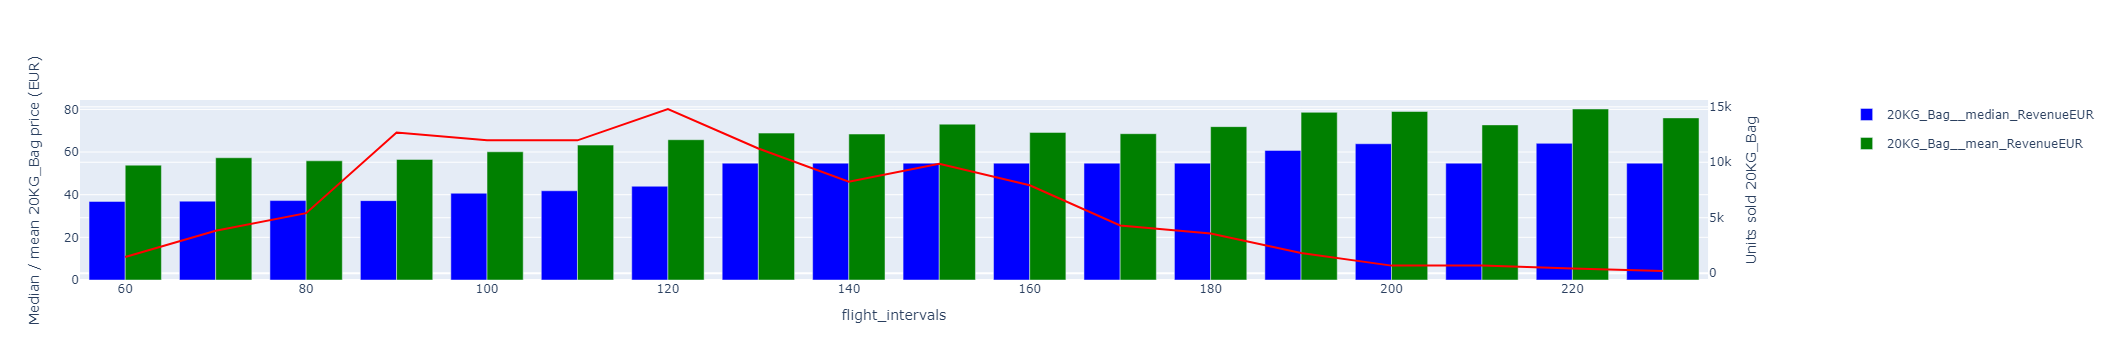



Priority_Boarding, CITY:


C:\Users\garji\AppData\Local\Temp\ipykernel_14540\1814118050.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



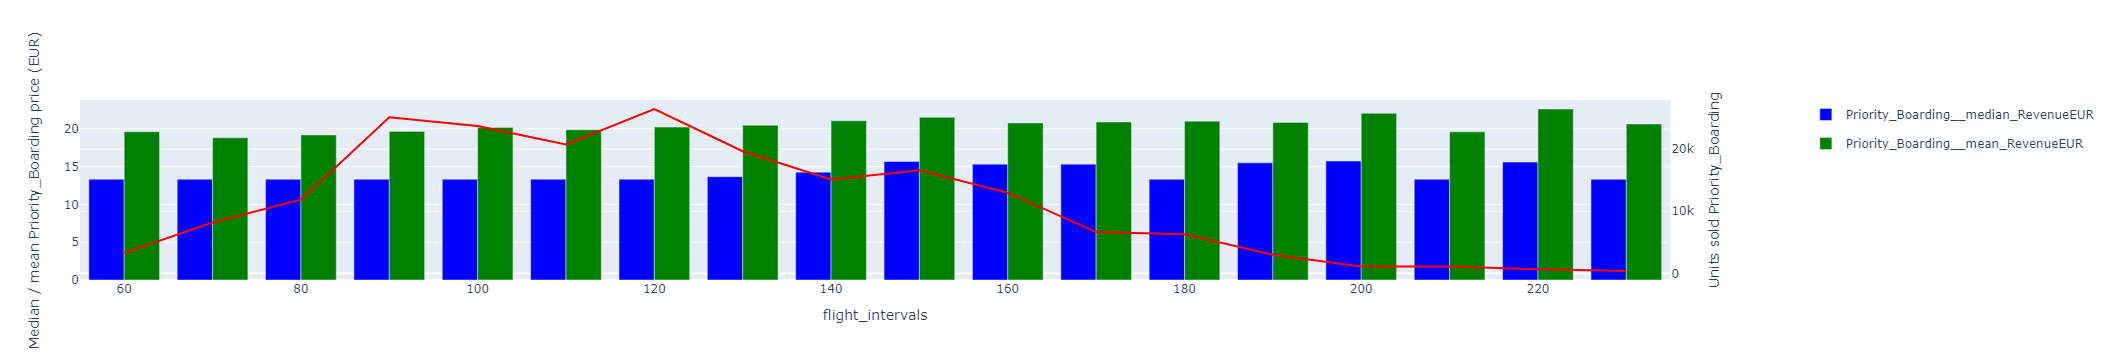



10KG_Bag, LEISURE:


C:\Users\garji\AppData\Local\Temp\ipykernel_14540\1814118050.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



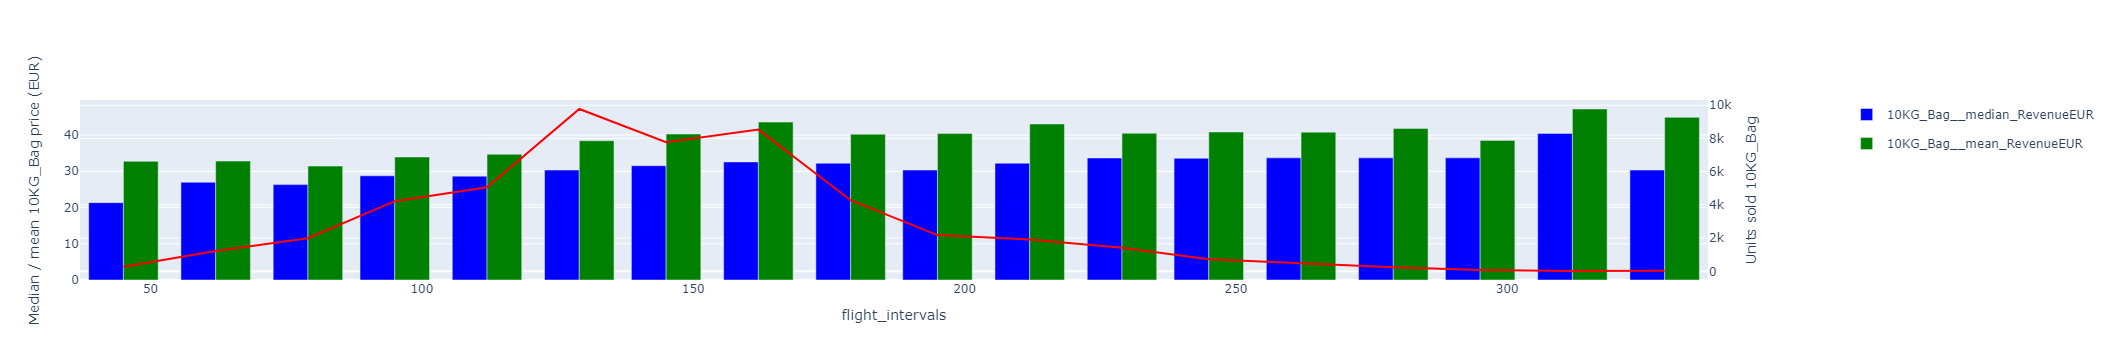



20KG_Bag, LEISURE:


C:\Users\garji\AppData\Local\Temp\ipykernel_14540\1814118050.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



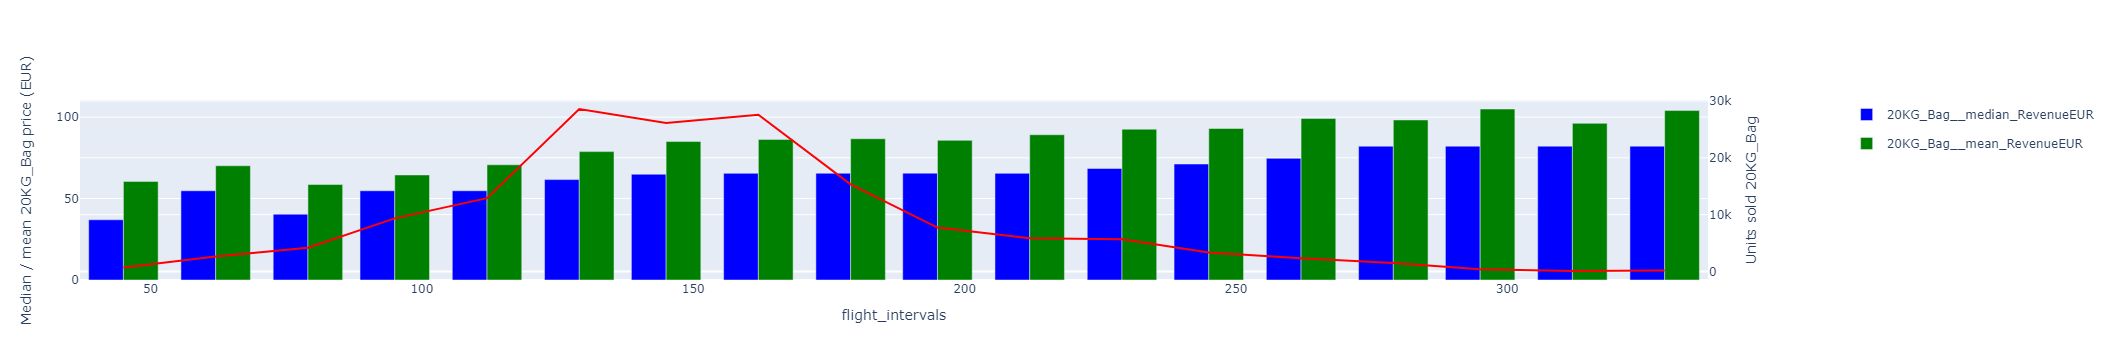



Priority_Boarding, LEISURE:


C:\Users\garji\AppData\Local\Temp\ipykernel_14540\1814118050.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



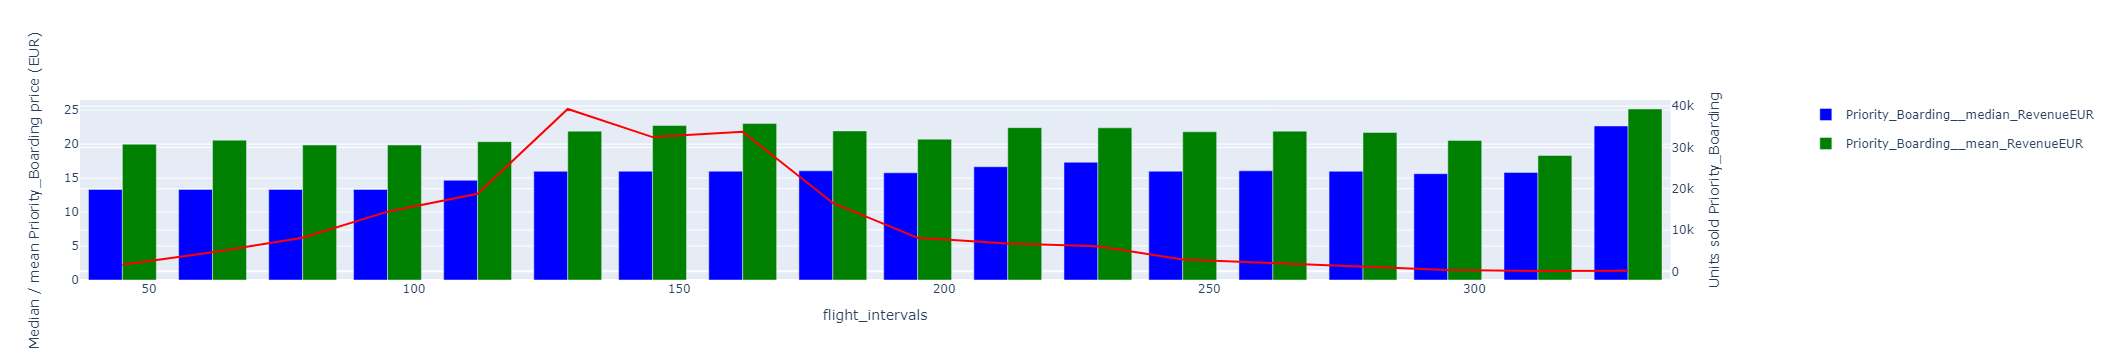



10KG_Bag, DOMESTIC:


C:\Users\garji\AppData\Local\Temp\ipykernel_14540\1814118050.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



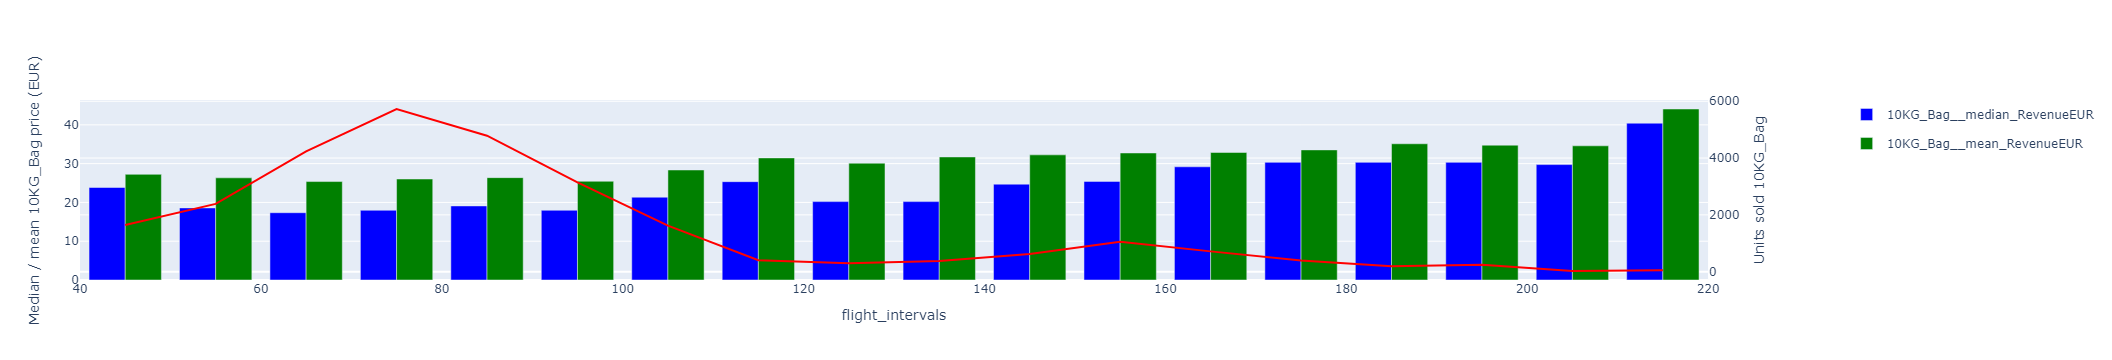



20KG_Bag, DOMESTIC:


C:\Users\garji\AppData\Local\Temp\ipykernel_14540\1814118050.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



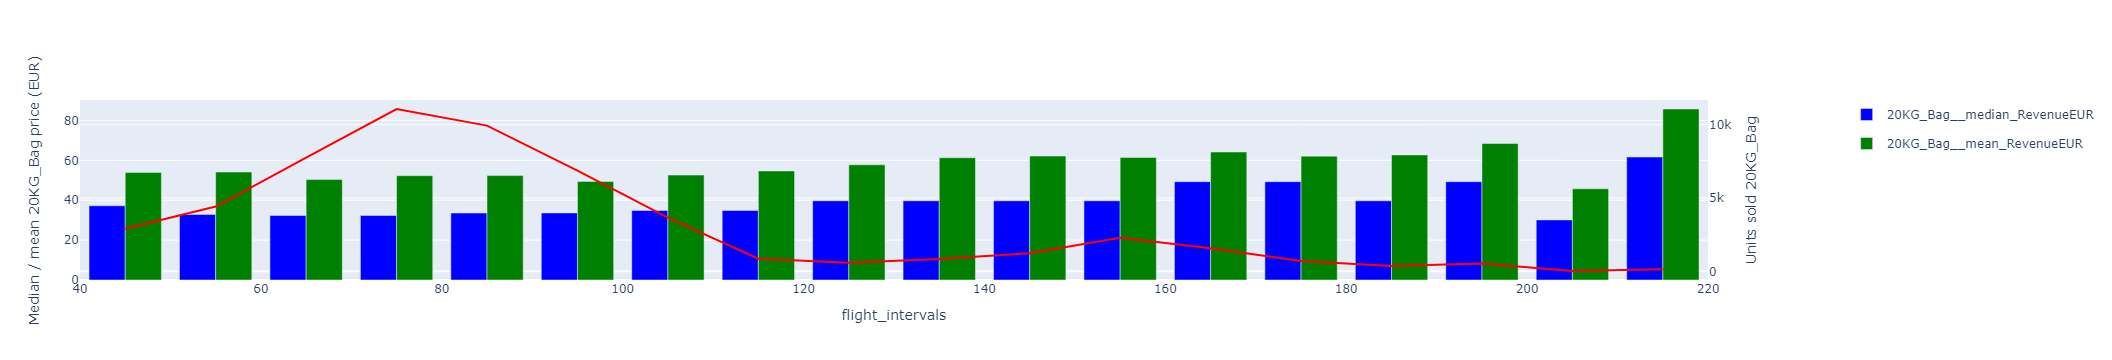



Priority_Boarding, DOMESTIC:


C:\Users\garji\AppData\Local\Temp\ipykernel_14540\1814118050.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



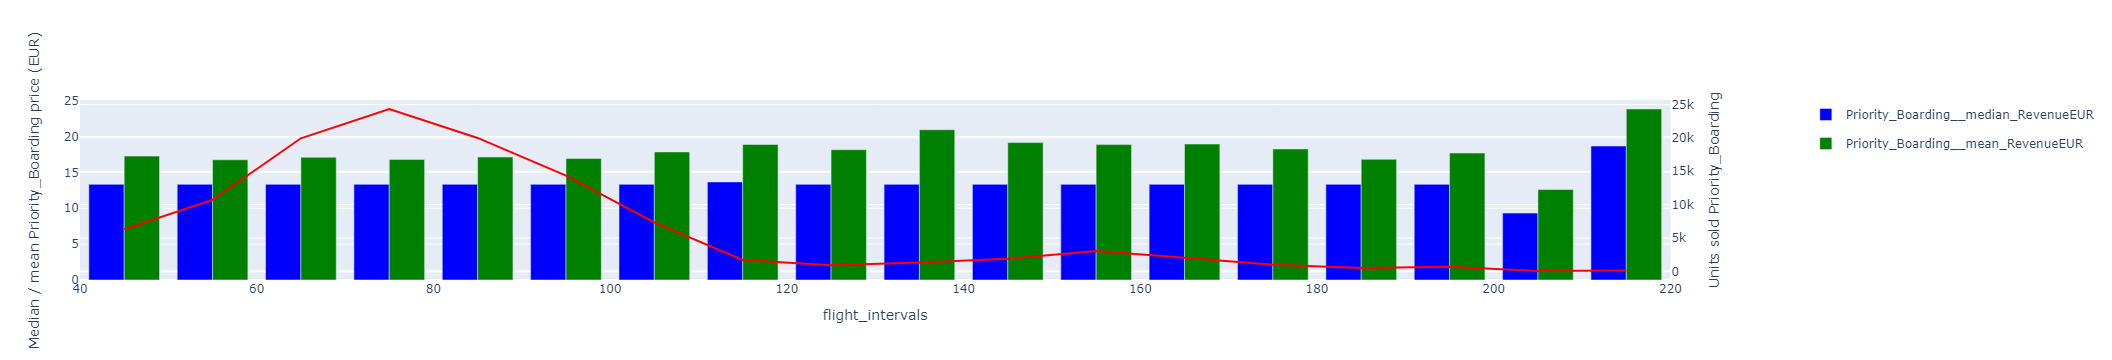

In [56]:
for j in data['RouteGroup'].unique():
    for i in ('10KG_Bag_', '20KG_Bag_', 'Priority_Boarding_'):
        print(i[:-1] + ', ' + j + ':')
        data2 = data[(data[i + 'RevenueEUR'] > 0) & (data['RouteGroup'] == j)]
        data2['flight_intervals'] = pd.cut(data2['flight_length_min'], bins = 18, right = True)
        data3 = data2.groupby(['flight_intervals']).agg({i + 'RevenueEUR': ['median', 'mean'], i + 'UnitsSold':	'sum'}).reset_index()
        data3['flight_intervals'] = data3['flight_intervals'].apply(lambda x: math.ceil(x.left)).astype("int")
        data3.columns = ['flight_intervals', i + '_median_' + 'RevenueEUR', i + '_mean_' + 'RevenueEUR', i + 'Units_sold']
    
        subfig = make_subplots(specs=[[{"secondary_y": True}]])
    
        color_discrete_map = {i + '_median_' + 'RevenueEUR': 'blue', i + '_mean_' + 'RevenueEUR': 'green'}

        # create two independent figures with px.line each containing data from multiple columns
        fig = px.bar(data3, x = 'flight_intervals', y = [i + '_median_' + 'RevenueEUR', i + '_mean_' + 'RevenueEUR'], color_discrete_map  = color_discrete_map)
        fig2 = px.line(data3, x = 'flight_intervals', y = i + 'Units_sold')
        fig2.update_traces(line_color = 'red')

        fig2.update_traces(yaxis="y2")

        subfig.add_traces(fig.data + fig2.data)
        subfig.layout.xaxis.title = "flight_intervals"
        subfig.layout.yaxis.title = 'Median / mean ' + i[:-1] + ' price (EUR)'
        subfig.layout.yaxis2.title = 'Units sold ' + i[:-1]
    
        # subfig.add_hline(y = np.mean(data3[i + 'RevenueEUR']), line_width=3, line_dash="dash", line_color="green")
    
        subfig.show()
        subfig.write_html('./Graphs/'+ i + j + '_mean_median_revenue_per_flight_length.html')
        subfig.write_image('./Graphs/'+ i + j + '_mean_median_revenue_per_flight_length.png')
        print('\r\n')

# Flight departure local time and priority boarding

As we can see, the median and mean price is higher at 12 am than in other times, and lower at 1 am.

Recommendation: increase the price whwn the number of priority boardings sold is high (e.g. 6am and 5 pm).

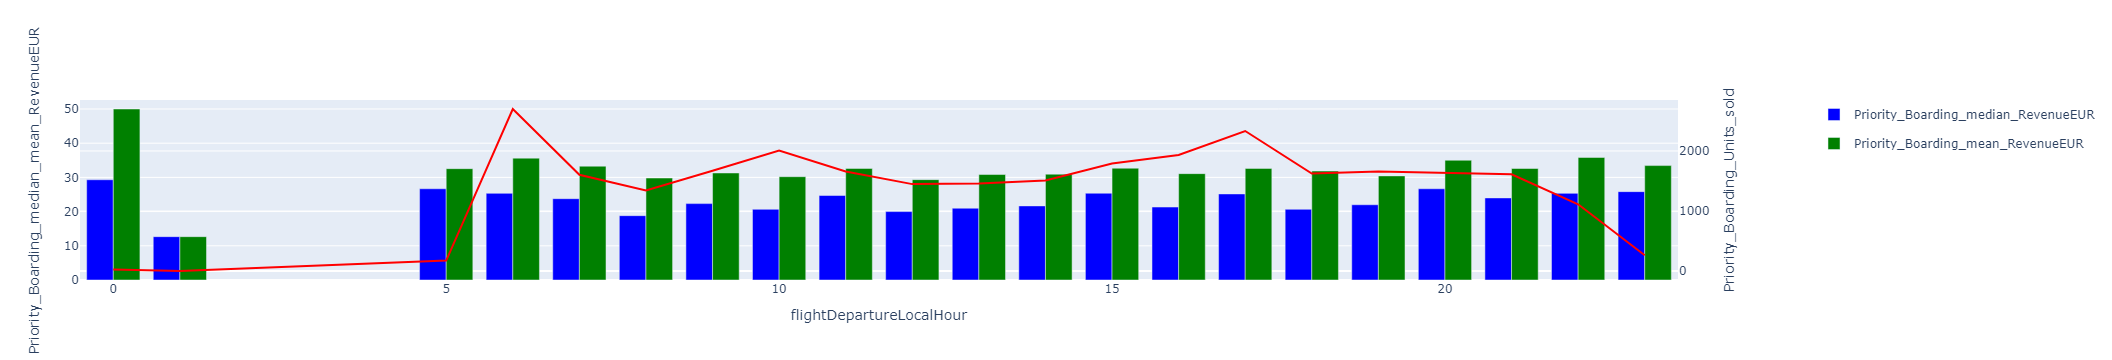

In [72]:
data2 = data[data['Priority_Boarding_RevenueEUR'] > 0]
data3 = data2.groupby(['flightDepartureLocalHour']).agg({'Priority_Boarding_RevenueEUR': ['median', 'mean'], 'Priority_Boarding_UnitsSold': 'sum'}).reset_index()
data3.columns = ['flightDepartureLocalHour', 'Priority_Boarding_median_RevenueEUR', 'Priority_Boarding_mean_RevenueEUR', 'Priority_Boarding_Units_sold']
    
subfig = make_subplots(specs=[[{"secondary_y": True}]])
    
color_discrete_map = {'Priority_Boarding_median_RevenueEUR': 'blue', 'Priority_Boarding_mean_RevenueEUR': 'green'}

# create two independent figures with px.line each containing data from multiple columns
fig = px.bar(data3, x = 'flightDepartureLocalHour', y = ['Priority_Boarding_median_RevenueEUR', 'Priority_Boarding_mean_RevenueEUR'], color_discrete_map = color_discrete_map)
fig2 = px.line(data3, x = 'flightDepartureLocalHour', y = 'Priority_Boarding_Units_sold')
fig2.update_traces(line_color = 'red')

fig2.update_traces(yaxis="y2")

subfig.add_traces(fig.data + fig2.data)
subfig.layout.xaxis.title = "flightDepartureLocalHour"
subfig.layout.yaxis.title = 'Priority_Boarding_median_mean_RevenueEUR'
subfig.layout.yaxis2.title = 'Priority_Boarding_Units_sold'
    
# subfig.add_hline(y = np.mean(data3[i + 'RevenueEUR']), line_width=3, line_dash="dash", line_color="green")
    
subfig.show()
subfig.write_html('./Graphs/Priority_Boarding_median_mean_revenue_per_local_departure_hour.html')
subfig.write_image('./Graphs/Priority_Boarding_median_mean_revenue_per_local_departure_hour.png')

# Flight arrival local time and priority boarding

As we can see, the median and mean price is higher at 1 am than in other times, and lower at 2 am.

Recommendation: increase the price whwn the number of priority boardings sold is high (e.g. 12pm and 11 pm).

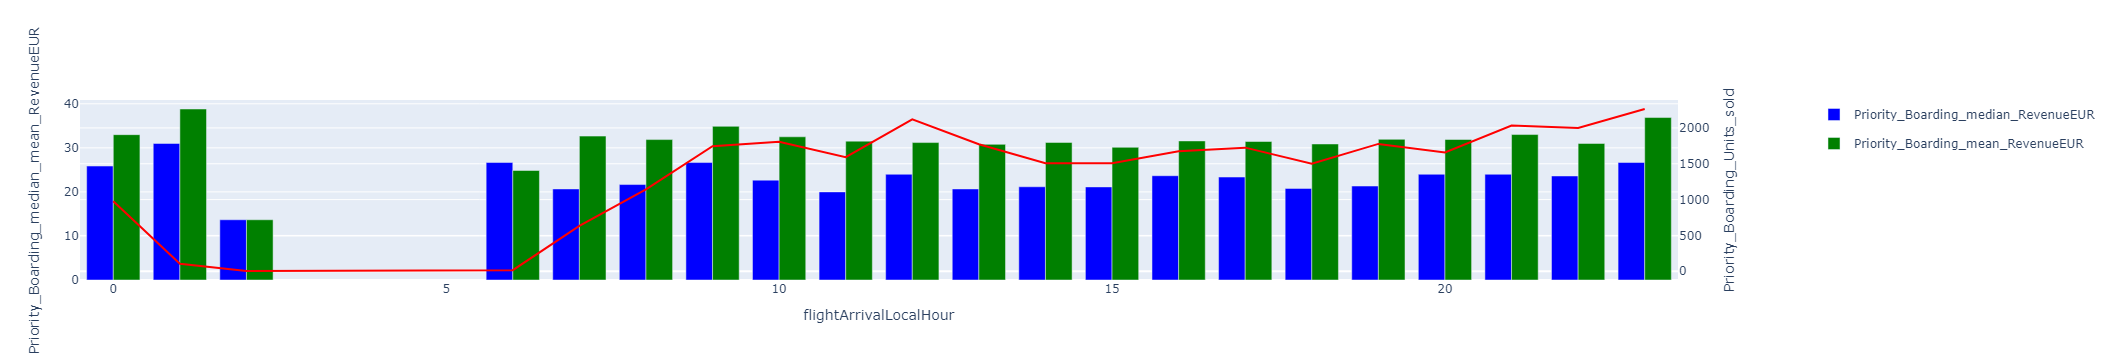

In [73]:
data2 = data[data['Priority_Boarding_RevenueEUR'] > 0]
data3 = data2.groupby(['flightArrivalLocalHour']).agg({'Priority_Boarding_RevenueEUR': ['median', 'mean'], 'Priority_Boarding_UnitsSold': 'sum'}).reset_index()
data3.columns = ['flightArrivalLocalHour', 'Priority_Boarding_median_RevenueEUR', 'Priority_Boarding_mean_RevenueEUR', 'Priority_Boarding_Units_sold']
    
subfig = make_subplots(specs=[[{"secondary_y": True}]])
    
color_discrete_map = {'Priority_Boarding_median_RevenueEUR': 'blue', 'Priority_Boarding_mean_RevenueEUR': 'green'}

# create two independent figures with px.line each containing data from multiple columns
fig = px.bar(data3, x = 'flightArrivalLocalHour', y = ['Priority_Boarding_median_RevenueEUR', 'Priority_Boarding_mean_RevenueEUR'], color_discrete_map = color_discrete_map)
fig2 = px.line(data3, x = 'flightArrivalLocalHour', y = 'Priority_Boarding_Units_sold')
fig2.update_traces(line_color = 'red')

fig2.update_traces(yaxis="y2")

subfig.add_traces(fig.data + fig2.data)
subfig.layout.xaxis.title = "flightArrivalLocalHour"
subfig.layout.yaxis.title = 'Priority_Boarding_median_mean_RevenueEUR'
subfig.layout.yaxis2.title = 'Priority_Boarding_Units_sold'
    
# subfig.add_hline(y = np.mean(data3[i + 'RevenueEUR']), line_width=3, line_dash="dash", line_color="green")
    
subfig.show()
subfig.write_html('./Graphs/Priority_Boarding_median_mean_revenue_per_local_arrival_hour.html')
subfig.write_image('./Graphs/Priority_Boarding_median_mean_revenue_per_local_arrival_hour.png')

# Flight status and priority boarding

As sample is not randomly selected (there are factors that determine whether a flight is or not cancelled), I determined that it was better to perform a non-parametric test to detect if there were statistical signifficant differences across flight status.

There are statistical differences across flight status, but as we can check on the graph below, this difference is better explained by the number of priority boardings tickets sold at each one.

In [137]:
data = flights[['InventoryLegSK', 'FlightStatus']].merge(sales[['InventoryLegSK', 'Priority_Boarding_UnitsSold', 'Priority_Boarding_RevenueEUR']], how = 'inner', on = 'InventoryLegSK')
data2 = data[data['Priority_Boarding_RevenueEUR'] > 0]

In [138]:
stats.mannwhitneyu(x = data2[data2['FlightStatus'] == 'Departed']['Priority_Boarding_RevenueEUR'], y = data2[data2['FlightStatus'] == 'Cancelled']['Priority_Boarding_RevenueEUR'], alternative = 'two-sided')

MannwhitneyuResult(statistic=60753902.0, pvalue=7.795090450665486e-06)

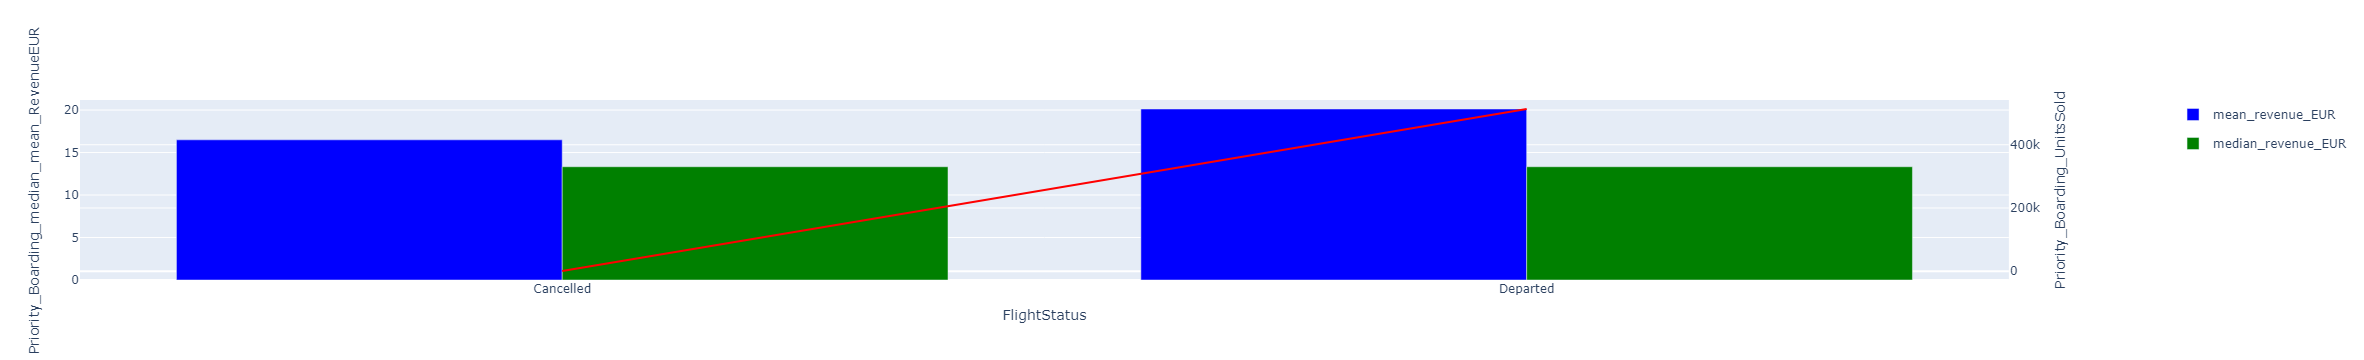

In [139]:
data2 = data2.groupby(['FlightStatus']).agg({'Priority_Boarding_RevenueEUR':['mean', 'median'], 'Priority_Boarding_UnitsSold':'sum'}).reset_index()
data2.columns = ['FlightStatus', 'mean_revenue_EUR', 'median_revenue_EUR', 'Priority_Boarding_UnitsSold']

subfig = make_subplots(specs=[[{"secondary_y": True}]])

color_discrete_map = {'mean_revenue_EUR': 'blue', 'median_revenue_EUR': 'green'}

fig = px.bar(data2, x = 'FlightStatus', y = ['mean_revenue_EUR', 'median_revenue_EUR'], barmode='group', color_discrete_map = color_discrete_map)
fig2 = px.line(data2, x = 'FlightStatus', y = 'Priority_Boarding_UnitsSold')
fig2.update_traces(line_color = 'red')

fig2.update_traces(yaxis="y2")

subfig.add_traces(fig.data + fig2.data)
subfig.layout.xaxis.title = "FlightStatus"
subfig.layout.yaxis.title = 'Priority_Boarding_median_mean_RevenueEUR'
subfig.layout.yaxis2.title = 'Priority_Boarding_UnitsSold'
    
# subfig.add_hline(y = np.mean(data3[i + 'RevenueEUR']), line_width=3, line_dash="dash", line_color="green")
    
subfig.show()
subfig.write_html('./Graphs/Priority_Boarding_median_mean_revenue_per_flight status.html')
subfig.write_image('./Graphs/Priority_Boarding_median_mean_revenue_per_flight status.png')